# 1. Chargement du dataset

In [1]:
from pathlib import Path
csv_pvf10 = "../data/processed/structure_pvf_10.csv"
results_dir = "ML_images_results_SVM"
Path(results_dir).mkdir(parents=True, exist_ok=True)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Charger le dataframe à partir du dataset
def load_df_from_dataset(csv_path,*,format,originalTrainTest=False,removeCarre=False):
    # Charger le fichier CSV et filtrer sur le format sélectionné
    df_pvf10 = pd.read_csv(csv_path)
    df_pvf10 = df_pvf10.loc[(df_pvf10['Format'] == format)]
    # Si on utilise le découpage train/test proposé par les créateurs du dataset
    if originalTrainTest:
        df_train = df_pvf10.loc[(df_pvf10['Train_Test'] == 'train')]  
        df_test = df_pvf10.loc[(df_pvf10['Train_Test'] == 'test')] 
        X_train = df_train.drop('Classe',axis=1)
        y_train = df_train['Classe']
        X_test = df_test.drop('Classe',axis=1)
        y_test = df_test['Classe']
    # Sinon si on retire les images carrées mises en doute lors de l'analyse exploratoire
    elif removeCarre:
        df_pvf10 = df_pvf10.loc[~df_pvf10['Doute_Carre']]
        # découpage train/test en 80/20 avec conservation de la répartition des classes
        X = df_pvf10.drop('Classe',axis=1)
        y = df_pvf10['Classe']
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    # Sinon découpage train/test en 80/20 avec conservation de la répartition des classes
    else:
        X = df_pvf10.drop('Classe',axis=1)
        y = df_pvf10['Classe']
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="110x60")
print ("Nb d'images ensemble d'entraînement :",X_train.shape[0])
print ("Nb d'images ensemble de test :",X_test.shape[0])
print ("-"*20)
print ("Répartition des classes, ensemble d'entraînement :")
print(y_train.value_counts(normalize=True))
print ("-"*20)
print ("Répartition des classes, ensemble de test :")
print(y_test.value_counts(normalize=True))

pd.set_option('display.max_columns', None)

Nb d'images ensemble d'entraînement : 4457
Nb d'images ensemble de test : 1115
--------------------
Répartition des classes, ensemble d'entraînement :
Classe
healthy panel             0.271932
hot cell                  0.169396
junction box heat         0.143594
substring open circuit    0.106574
short circuit panel       0.076509
Debris cover              0.073592
bottom dirt               0.067759
shadow                    0.054297
break                     0.023558
string short circuit      0.012789
Name: proportion, dtype: float64
--------------------
Répartition des classes, ensemble de test :
Classe
healthy panel             0.271749
hot cell                  0.169507
junction box heat         0.143498
substring open circuit    0.106726
short circuit panel       0.077130
Debris cover              0.073543
bottom dirt               0.067265
shadow                    0.054709
break                     0.023318
string short circuit      0.012556
Name: proportion, dtype: float64


# 2. Définition de transformeurs pour extraction de features

### Transformeur 1 : vecteurs HOG

In [3]:
import cv2
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin

# Transformeur qui renvoie le dataframe des vecteurs HOG
class HOGExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110), pixels_per_cell=(8,8),cells_per_block=(2,2)):
        self.image_size = image_size
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.feature_names_ = None

    # Méthode d'extraction du vecteur HOG d'une image
    def extract_hog(self, gray_img):
        hog_vector = hog(
            gray_img,
            orientations=9,
            pixels_per_cell=self.pixels_per_cell,
            cells_per_block=self.cells_per_block,
            feature_vector=True
        )
        return hog_vector
    
    # Le fit ne sert qu'à récupérer le nom des features créées
    def fit(self, X, y=None):
        # On utilise une seule image
        img = cv2.imread(X['Chemin'].iloc[0])
        # Conversion en niveaux de gris et resizing
        img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
        # Extraction du vecteur HOG
        hog_vector = self.extract_hog(img_gray_resized)
        # On en déduit le nom des features
        self.feature_names_ =  [f'HOG_{i+1}' for i in range(len(hog_vector))]
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs HOG
        hog_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur HOG
            hog_vector = self.extract_hog(img_gray_resized)
            hog_vectors.append(hog_vector)
        # On renvoie le dataframe des vecteurs HOG
        return pd.DataFrame(hog_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

### Transformeur 2 : vecteurs GLCM 

In [4]:
from skimage.feature import graycomatrix, graycoprops

# Transformeur qui renvoie le dataframe des caractéristiques GLCM
class GLCMExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110),
                 glcm_distances=[1],
                 glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                 glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']):
        self.image_size = image_size
        self.glcm_distances = glcm_distances
        self.glcm_angles = glcm_angles
        self.glcm_props = glcm_props
        # On détermine le nom des features GLCM à extraire
        self.feature_names_ = []
        # Pour chaque propriété, chaque distance et chaque angle
        for prop in self.glcm_props:
            for distance in self.glcm_distances:
                for angle in self.glcm_angles:
                    # On stocke dans les noms des features un label du type : contrast_d1_a45
                    self.feature_names_.append(f"{prop}_d{distance}_a{np.degrees(angle):.0f}")

    # Méthode d'extraction des caractéristiques GLCM d'une image
    def extract_glcm(self, gray_img):
        glcm_vector = []
        # Calcul de la matrice GLCM (256 x 256 x distances x angles)
        glcm = graycomatrix(
            gray_img,
            distances=self.glcm_distances,
            angles=self.glcm_angles,
            levels=256
        )
        # Pour chaque propriété GLCM
        for prop in self.glcm_props:
            # On la calcule pour les différentes distances et les différents angles 
            prop_matrix = graycoprops(glcm, prop)  # Matrice distances x angles
            # On transforme la matrice en vecteur qu'on stocke dans glcm_vector
            glcm_vector.extend(prop_matrix.flatten())
        return glcm_vector      

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs GLCM
        glcm_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur GLCM
            glcm_vector = self.extract_glcm(img_gray_resized)
            glcm_vectors.append(glcm_vector)
        # On renvoie le dataframe des vecteurs GLCM
        return pd.DataFrame(glcm_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

### Transformeur 3 : vecteurs Entropie

In [5]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy.stats import skew, kurtosis

# Transformeur qui renvoie le dataframe des caractéristiques de l'entropie
class EntropyExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110),radius=4, bins=10, include_histogram=True):
        self.image_size = image_size
        self.radius = radius
        self.bins = bins
        self.include_histogram = include_histogram
        # On détermine le nom des features Entropie à extraire
        self.feature_names_ = ['entropy_mean', 'entropy_std', 'entropy_min','entropy_max', 'entropy_median', 'entropy_skew', 'entropy_kurtosis']
        # Si histogramme demandé
        if include_histogram:
            self.feature_names_.extend([f'entropy_hist_bin{i+1}' for i in range(self.bins)])
        
    # Méthode d'extraction des caractéristiques de l'entropie d'une image
    def extract_entropy(self, gray_img):
        # Calcul de la carte d'entropie
        entropie = entropy(gray_img, disk(self.radius))
        # Calcul des statistiques associées
        entropy_vector = [
                np.mean(entropie),
                np.std(entropie),
                np.min(entropie),
                np.max(entropie),
                np.median(entropie),
                skew(entropie.ravel()),
                kurtosis(entropie.ravel())
            ]
        # Si histogramme demandé
        if (self.include_histogram):
            hist, bin_edges = np.histogram(entropie, bins=self.bins, range=(0, np.max(entropie)), density=True)
            # On l'ajoute au vecteur des caractéristiques de l'entropie
            entropy_vector.extend(list(hist))

        return entropy_vector      

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs caractéristiques de l'entropie
        entropy_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur de l'entropie
            entropy_vector = self.extract_entropy(img_gray_resized)
            entropy_vectors.append(entropy_vector)
        # On renvoie le dataframe des vecteurs de l'entropie
        return pd.DataFrame(entropy_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

### Transformeur 4 : densité de contours

In [6]:
from skimage.filters.rank import entropy

# Transformeur qui renvoie le dataframe des densités de contours
class EdgeDensityExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110),canny_threshold1=100,canny_threshold2=200):
        self.image_size = image_size
        self.canny_threshold1 = canny_threshold1
        self.canny_threshold2 = canny_threshold2
        # On détermine le nom des features Entropie à extraire
        self.feature_names_ = ['edge_density']
        
    # Méthode d'extraction de le densité de contours d'une image
    def extract_edge_density(self, gray_img):
        edges = cv2.Canny(gray_img, self.canny_threshold1, self.canny_threshold2)
        return np.sum(edges > 0) / edges.size     

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les densités de contours
        edge_densities = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage de la densité de contour (on rogne 2 pixels sur les bords)
            edge_density = self.extract_edge_density(img_gray_resized[2:self.image_size[1]-1,2:self.image_size[0]-1])
            edge_densities.append(edge_density)
        # On renvoie le dataframe des densités de contours (1 feature)
        return pd.DataFrame({self.feature_names_[0]:edge_densities},index=X.index)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

### Transformeur 5 : pixels bruts

In [7]:
# Transformeur qui renvoie le dataframe des pixels bruts
class PixelsBrutsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(30,55)):
        self.image_size = image_size
        # Nom des features : Pixel1, Pixel2...
        self.feature_names_ = [f"Pixel{i+1}" for i in range(image_size[0]*image_size[1])]  

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs des pixels bruts
        brut_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur des pixels bruts
            brut_vector = img_gray_resized.flatten()
            brut_vectors.append(brut_vector)
        # On renvoie le dataframe des vecteurs des pixels bruts
        return pd.DataFrame(brut_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_
    
# Création du transformeur
pixbrut_extr = PixelsBrutsExtractor()

### Transformeur 6 : réduction de dimensions basée sur UMAP

In [8]:
import umap

class UMAPTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=15, n_components=2, min_dist=0.1):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.min_dist = min_dist
        self.umap = None

    def fit(self, X, y=None):
        self.umap = umap.UMAP(
            n_neighbors=self.n_neighbors,
            n_components=self.n_components,
            min_dist=self.min_dist,
            random_state=42
        )
        self.umap.fit(X)
        return self

    def transform(self, X):
        return self.umap.transform(X)

d:\Sources\DS-projet\SEP24-CDS-PHOTOVOLTAIQUE\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3. Définition d'une pipeline et grille de paramétrage

### Pipeline preprocessing + SVM : étapes par défaut

In [9]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler
from sklearn.feature_selection import SelectPercentile,mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler,ClusterCentroids
from imblearn.combine import SMOTETomek,SMOTEENN
from sklearn.svm import SVC

# Pour les extracteurs, on part sur les paramètres utilisés lors de l'analyse exploratoire
default_steps = {
    'hog':HOGExtractor(image_size=(60,110),pixels_per_cell=(8,8),cells_per_block=(2,2)),
    'glcm':GLCMExtractor(image_size=(60,110),glcm_distances=[1],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                         glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']),
    'entropie':EntropyExtractor(image_size=(60,110),radius=4, bins=10, include_histogram=True),
    'canny':EdgeDensityExtractor(image_size=(60,110),canny_threshold1=100,canny_threshold2=200),
    'brut':PixelsBrutsExtractor(image_size=(30,55)),
    'scaler':StandardScaler(),
    'reduction':PCA(0.9),
    'sampler':SMOTE(),
    'clf':SVC(kernel="rbf", gamma="scale",C=10)                       
}
# Pipeline = extraction des features + mise à l'échelle + sélection/réduction + rééchantillonnage + classifieur
pipeline = ImbPipeline([
    ('features', FeatureUnion([
        ('hog', default_steps['hog']),
        ('glcm', default_steps['glcm']),
        ('entropie',default_steps['entropie']),
        ('canny',default_steps['canny']),
        ('brut',default_steps['brut'])
    ])),
    ('scaler', default_steps['scaler']),
    ('reduction', default_steps['reduction']),
    ('sampler', default_steps['sampler']),
    ('clf', default_steps['clf'])
])


### Grille de paramétrage dynamique

Pour un temps de calcul raisonnable, nous ne pouvons pas appliquer une seule grille de paramétrage pour l'ensemble des étapes de la pipeline. Les combinaisons possibles d'extraction, de mise à l'échelle, de réduction de dimension, de rééchantillonnage et d'hyperparamètres du classifieur sont beaucoup trop nombreuses.

On va ainsi fixer des **grilles de paramétrage par étape** :
- d'abord on cherchera les paramètres optimaux pour chacun des 5 extracteurs 
- ensuite on testera différentes combinaisons d'extraction et de mise à l'échelle
- une fois cette partie d'extraction + mise à l'échelle choisie, on optimisera la réduction de dimensions et les hyperparamètres du classifieur
- puis on testera des techniques de rééchantillonnage

C'est pourquoi nous allons faire une fonction de construction "dynamique" d'une grille de paramétrage. Pour chaque étape de la pipeline, 3 options sont possibles :
- "no" => on n'applique pas l'étape
- "one" => on applique le transformeur par défaut pour cette étape
- "all" => on teste toutes les possibilités listées pour cette étape



In [10]:
# Fonction de construction d'une grille de paramétrage pour la pipeline
def build_param_grid(default_steps,*,brut="no", hog="no", glcm="no",entropie="no", canny="no", scaler="no", reduction="no", sampler="no", clf="one"):
    param_grid = {}

    # Étapes d'extraction des features

    # Si aucune extraction
    if brut=="no" and hog=="no" and glcm=="no" and entropie=="no" and canny=="no":
        # On conserve les données d'entrée de la pipeline
        param_grid['features'] = ['passthrough']
    # Si au moins une étape d'extraction
    else:

        # Pour HOG
        if hog=="all":
            # On fait varier pixels_per_cell et cells_per_block
            param_grid['features__hog'] = [HOGExtractor(image_size=(60,110),pixels_per_cell=(8,8),cells_per_block=(2,2)),
                                        HOGExtractor(image_size=(60,110),pixels_per_cell=(8,8),cells_per_block=(3,3)),
                                        HOGExtractor(image_size=(60,110),pixels_per_cell=(12,12),cells_per_block=(2,2)),
                                        HOGExtractor(image_size=(60,110),pixels_per_cell=(12,12),cells_per_block=(3,3)),
                                        HOGExtractor(image_size=(60,110),pixels_per_cell=(16,16),cells_per_block=(2,2)),
                                        HOGExtractor(image_size=(60,110),pixels_per_cell=(16,16),cells_per_block=(3,3))]
        elif hog=="one":
            param_grid['features__hog'] = [default_steps['hog']]
        else:
            param_grid['features__hog'] = ['drop']

        # Pour GLCM
        if glcm=="all":
            # On fait varier la distance de voisinage des pixels observés et les propriétés à calculer
            # (d'abord toutes les propriétés, puis uniquement contraste et énergie qui semblaient les plus prometteuses lors de l'analyse exploratoire)
            param_grid['features__glcm'] = [GLCMExtractor(image_size=(60,110),glcm_distances=[1],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                        glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']),
                                            GLCMExtractor(image_size=(60,110),glcm_distances=[4],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                        glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']),
                                            GLCMExtractor(image_size=(60,110),glcm_distances=[8],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                        glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']),
                                            GLCMExtractor(image_size=(60,110),glcm_distances=[1],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                        glcm_props=['contrast','energy']),
                                            GLCMExtractor(image_size=(60,110),glcm_distances=[4],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                        glcm_props=['contrast','energy']),
                                            GLCMExtractor(image_size=(60,110),glcm_distances=[8],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                        glcm_props=['contrast','energy'])]
        elif glcm=="one":
            param_grid['features__glcm'] = [default_steps['glcm']]
        else:
            param_grid['features__glcm'] = ['drop']

        # Pour Entropie
        if entropie=="all":
            # On fait varier la taille du disque d'entropie et l'utilisation ou non d'un histogramme en plus des statistiques de l'entropie
            param_grid['features__entropie'] = [EntropyExtractor(image_size=(60,110),radius=4, bins=10, include_histogram=True),
                                                EntropyExtractor(image_size=(60,110),radius=4, bins=20, include_histogram=True),
                                                EntropyExtractor(image_size=(60,110),radius=2, bins=10, include_histogram=True),
                                                EntropyExtractor(image_size=(60,110),radius=2, bins=20, include_histogram=True),
                                                EntropyExtractor(image_size=(60,110),radius=4, bins=10, include_histogram=False),
                                                EntropyExtractor(image_size=(60,110),radius=4, bins=20, include_histogram=False),
                                                EntropyExtractor(image_size=(60,110),radius=2, bins=10, include_histogram=False),
                                                EntropyExtractor(image_size=(60,110),radius=2, bins=20, include_histogram=False)]
        elif entropie=="one":
            param_grid['features__entropie'] = [default_steps['entropie']]
        else:
            param_grid['features__entropie'] = ['drop']
        
        # Pour Canny
        if canny=="all":
            # On fait varier les seuils du filtre de Canny
            param_grid['features__canny'] = [EdgeDensityExtractor(image_size=(60,110),canny_threshold1=100,canny_threshold2=200),
                                            EdgeDensityExtractor(image_size=(60,110),canny_threshold1=50,canny_threshold2=150),
                                            EdgeDensityExtractor(image_size=(60,110),canny_threshold1=30,canny_threshold2=100),
                                            EdgeDensityExtractor(image_size=(60,110),canny_threshold1=70,canny_threshold2=140)]
        elif canny=="one":
            param_grid['features__canny'] = [default_steps['canny']]
        else:
            param_grid['features__canny'] = ['drop']

        # Pour Pixels bruts
        if brut=="all":
            # On fait varier la taille de l'image pour l'extraction des pixels bruts
            param_grid['features__brut'] = [PixelsBrutsExtractor(image_size=(30,55)),
                                            PixelsBrutsExtractor(image_size=(60,110)),
                                            PixelsBrutsExtractor(image_size=(45,83)),
                                            PixelsBrutsExtractor(image_size=(15,28))]
        elif brut=="one":
            param_grid['features__brut'] = [default_steps['brut']]
        else:
            param_grid['features__brut'] = ['drop']

    # Mise à l'échelle
    if scaler=="all":
        param_grid['scaler'] = [MinMaxScaler(),StandardScaler(),RobustScaler()]
    elif scaler =="one":
        param_grid['scaler'] = [default_steps['scaler']]
    else:
        param_grid['scaler'] =['passthrough']

    # Réduction de dimension
    if reduction == "all":
        param_grid['reduction'] = [SelectPercentile(mutual_info_classif,percentile=10),SelectPercentile(mutual_info_classif,percentile=20),SelectPercentile(mutual_info_classif,percentile=50),
                                   PCA(0.9),PCA(0.95),PCA(0.99),
                                   LDA(),
                                   UMAPTransformer(15,10,0.1),UMAPTransformer(15,20,0.1),UMAPTransformer(15,50,0.1),
                                   'passthrough']
    elif reduction == "one":
        param_grid['reduction'] = [default_steps['reduction']]
    else:
        param_grid['reduction'] = ['passthrough']

    # Rééchantillonnage
    if sampler== "all":
        param_grid['sampler'] = [RandomOverSampler(),SMOTE(),ADASYN(),
                                 RandomUnderSampler(),ClusterCentroids(),
                                 SMOTETomek(),SMOTEENN(),
                                 'passthrough']
    elif sampler== "one":
        param_grid['sampler'] = [default_steps['sampler']]
    else:
        param_grid['sampler'] = ['passthrough']

    # Hyperparamètres du classifieur SVM
    if clf== "all":
        param_grid['clf__C'] = [0.1,1,10]
        param_grid['clf__kernel'] = ['rbf','linear']
        param_grid['clf__gamma'] = ['scale','auto']
    else:
        param_grid['clf'] = [default_steps['clf']]

    return param_grid

### Fonction de validation croisée

In [11]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

# Fonction de validation croisée d'une pipeline avec GridSearch
def cross_validation(pipe,param_grid,X_train,y_train) : 
    # Création d'une Grid Search avec 5 folds (avec répartition des classes conservée)
    # On cherche le meilleur f1-score macro
    pipe_grid = GridSearchCV(pipe,param_grid,cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                         scoring={'accuracy': 'accuracy','f1_macro': 'f1_macro'},refit='f1_macro',n_jobs=-1)
    # Entraînement
    pipe_grid.fit(X_train,y_train)
    # Affichage des résultats (classement par f1-score macro)
    cv_results = pd.DataFrame(pipe_grid.cv_results_).sort_values('mean_test_f1_macro',ascending=False)
    display (cv_results)
    print ("Best params (f1 macro) : ",pipe_grid.best_params_)
    print ("Best score (f1 macro): ",pipe_grid.best_score_)
    # Renvoyer les résultats de la cross-validation et un dico avec la meilleure pipeline fittée, ses paramètres et ses scores
    best_idx = pipe_grid.best_index_
    dico_best_pipe = {
        "fitted_pipe":pipe_grid.best_estimator_,
        "params":pipe_grid.best_params_,
        "mean_accuracy":cv_results.loc[best_idx, 'mean_test_accuracy'],
        "std_accuracy":cv_results.loc[best_idx, 'std_test_accuracy'],
        "mean_f1_macro":cv_results.loc[best_idx, 'mean_test_f1_macro'],
        "std_f1_macro":cv_results.loc[best_idx, 'std_test_f1_macro'],
        "mean_fit_time":cv_results.loc[best_idx, 'mean_fit_time'],
        "mean_score_time":cv_results.loc[best_idx, 'mean_score_time']
        }
    return cv_results,dico_best_pipe

# 4. Optimisation des extracteurs

Avant de voir quelle combinaison d'extracteurs est la plus prometteuse, on commence par tester les différents paramètres d'extracteurs avec une pipeline simple : extracteur + StandardScaler + SVC 

### Validation croisée HOG + StandardScaler + SVM

In [18]:
# GridSearch HOG + StandardScaler + SVM
param_grid = build_param_grid(default_steps,hog="all",scaler="one",clf="one")
_,_ = cross_validation(pipeline,param_grid,X_train,y_train)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_clf  \
3      58.872797      6.918881        13.741715        1.002560  SVC(C=10)   
2      48.092631      2.567861        12.891766        0.318338  SVC(C=10)   
1     204.255462     43.144791        36.091571        6.050876  SVC(C=10)   
0     190.946798      0.921808        25.279485        0.173533  SVC(C=10)   
4      16.914597      0.689716         4.829621        0.361121  SVC(C=10)   
5      14.097132      0.382489         3.407656        0.946460  SVC(C=10)   

  param_features__brut param_features__canny param_features__entropie  \
3                 drop                  drop                     drop   
2                 drop                  drop                     drop   
1                 drop                  drop                     drop   
0                 drop                  drop                     drop   
4                 drop                  drop                     drop   
5                 drop                  drop                     drop   

  param_features__glcm                                param_features__hog  \
3                 drop  HOGExtractor(cells_per_block=(3, 3), pixels_pe...   
2                 drop             HOGExtractor(pixels_per_cell=(12, 12))   
1                 drop               HOGExtractor(cells_per_block=(3, 3))   
0                 drop                                     HOGExtractor()   
4                 drop             HOGExtractor(pixels_per_cell=(16, 16))   
5                 drop  HOGExtractor(cells_per_block=(3, 3), pixels_pe...   

  param_reduction param_sampler    param_scaler  \
3     passthrough   passthrough  MinMaxScaler()   
2     passthrough   passthrough  MinMaxScaler()   
1     passthrough   passthrough  MinMaxScaler()   
0     passthrough   passthrough  MinMaxScaler()   
4     passthrough   passthrough  MinMaxScaler()   
5     passthrough   passthrough  MinMaxScaler()   

                                              params  split0_test_accuracy  \
3  {'clf': SVC(C=10), 'features__brut': 'drop', '...              0.821749   
2  {'clf': SVC(C=10), 'features__brut': 'drop', '...              0.800448   
1  {'clf': SVC(C=10), 'features__brut': 'drop', '...              0.797085   
0  {'clf': SVC(C=10), 'features__brut': 'drop', '...              0.789238   
4  {'clf': SVC(C=10), 'features__brut': 'drop', '...              0.713004   
5  {'clf': SVC(C=10), 'features__brut': 'drop', '...              0.716368   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
3              0.780269              0.808081              0.805836   
2              0.771300              0.782267              0.795735   
1              0.779148              0.780022              0.799102   
0              0.754484              0.769921              0.773288   
4              0.681614              0.691358              0.693603   
5              0.692825              0.696970              0.687991   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
3              0.800224            0.803232           0.013487   
2              0.792368            0.788424           0.010438   
1              0.768799            0.784831           0.011544   
0              0.756453            0.768677           0.012621   
4              0.686869            0.693290           0.010678   
5              0.689113            0.696653           0.010347   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
3                   1              0.760084              0.680790   
2                   2              0.735978              0.663310   
1                   3              0.728555              0.670680   
0                   4              0.728353              0.646979   
4                   6              0.714695              0.621074   
5                   5              0.694140              0.623523   

   split2_test_f1_macro  split3_test_f1_macro  split4_

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7314754172210237


Pour HOG, on peut partir sur le quatrième **extracteur HOG (3) avec paramètres : pixels_per_cell=(12,12) et cells_per_block=(3,3)**.

C'est le meilleur au niveau du f1-score et de l'accuracy. Le temps de calcul reste raisonnable

### Validation croisée GLCM + StandardScaler + SVM

In [ ]:
# GridSearch GLCM + StandardScaler + SVM
param_grid = build_param_grid(default_steps,glcm="all",scaler="one",clf="one")
_,_ = cross_validation(pipeline,param_grid,X_train,y_train)

params  ...  std_test_f1_macro
2  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.027665
1  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.013427
0  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.013476
5  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.022983
4  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.020245
3  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.013704

[6 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8]), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.6197892820791306


Pour GLCM, on peut partir sur le sixième **extracteur GLCM (5) avec distance de 8 pixels et uniquement les propriétés contraste et énergie**.

On ne choisit pas parmi les 3 premiers car même s'ils ont un score plus élevé, le temps de calcul des propriétés GLCM devient prohibitif.

On ne choisit donc pas ici le best_estimator de la validation croisée. On cherchera plutôt à combiner un extracteur un peu moins performant (le 5) avec d'autres types d'extracteurs. 

### Validation croisée Entropie + StandardScaler + SVM

In [ ]:
# GridSearch Entropie + StandardScaler + SVM
param_grid = build_param_grid(default_steps,entropie="all",scaler="one",clf="one")
_,_ = cross_validation(pipeline,param_grid,X_train,y_train)

params  ...  std_test_f1_macro
3  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.018430
1  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.020678
0  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.017610
4  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.015309
5  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.015309
2  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.010642
6  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.022555
7  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.022555

[8 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20, radius=2), 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.4253024599524885


Pour l'entropie, on peut partir sur le deuxième **extracteur d'entropie (1) avec rayon du disque d'entropie de 4 pixels et histogramme de 20 intervalles**.

Certes l'extracteur 3 arrive en tête du f1 score, mais avec un écart de 0.05% seulement alors que son accuracy est inférieure de 2%.

### Validation croisée Canny + StandardScaler + SVM

In [ ]:
# GridSearch Canny + StandardScaler + SVM
param_grid = build_param_grid(default_steps,canny="all",scaler="one",clf="one")
_,_ = cross_validation(pipeline,param_grid,X_train,y_train)

params  ...  std_test_f1_macro
3  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.008394
1  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.009450
0  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.005949
2  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.006041

[4 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.2919430191543767


Pour la densité de contours, on peut partir sur le quatrième **extracteur de densité de contours (3) : avec seuils de Canny à 70 et 140**.

Au niveau du f1-score et de l'accuracy, on est sur les même niveaux que le second extracteur (le 1), mais le temps de calcul est  30% plus faible.

### Validation croisée Pixels bruts + StandardScaler + SVM

In [ ]:
# GridSearch Pixels Bruts + StandardScaler + SVM
param_grid = build_param_grid(default_steps,brut="all",scaler="one",clf="one")
_,_ = cross_validation(pipeline,param_grid,X_train,y_train)

params  ...  std_test_f1_macro
2  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.028111
1  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.030859
0  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.028159
3  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.030128

[4 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(45, 83)), 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.7114055026030518


Pour les pixels bruts, on peut partir sur le quatrième **extracteur de pixels bruts (3) : avec resizing de l'image à 15x28**.

La différence des scores est très faible par rapport aux différences de temps de calcul, on se base donc sur ce critère, on ne choisit donc pas ici le best_estimator de la validation croisée.

### => On fige les paramètres des extracteurs

In [12]:
# On met à jour les étapes d'extraction par défaut de la pipeline avec les paramètres optimaux trouvés
default_steps['hog']=HOGExtractor(image_size=(60,110),pixels_per_cell=(12,12),cells_per_block=(3,3))
default_steps['glcm']= GLCMExtractor(image_size=(60,110),glcm_distances=[8],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                     glcm_props=['contrast','energy'])
default_steps['entropie'] = EntropyExtractor(image_size=(60,110),radius=4, bins=20, include_histogram=True)
default_steps['canny'] = EdgeDensityExtractor(image_size=(60,110),canny_threshold1=70,canny_threshold2=140)
default_steps['brut'] = PixelsBrutsExtractor(image_size=(15,28))

# 5. Optimisation de la combinaison d'extracteurs + mise à l'échelle

Maintenant qu'on a décidé des paramètres à utiliser pour chaque extracteur, on va chercher quelle est la meilleure combinaison d'extracteurs et de mise à l'échelle pour le modèle SVM :
- On teste les combinaisons des 5 extracteurs optimaux trouvés ci-dessus. Entropie et Canny seuls ne sont pas testés car trop peu performants.
- Pour chaque combinaison, on teste les 3 scalers MinMax, Standard et Robust

In [26]:
# Pour stocker les résultats
pipeline_reports = {}

### Validation croisée de 20 combinaisons d'extracteurs + 3 scalers + SVM

In [ ]:
# GridSearchs avec différentes combinaisons d'extracteurs + les 3 scalers + svm
grid_comb_extract_scaler = {
    "HOG + scalers + SVM": build_param_grid(default_steps,hog="one",scaler="all",clf="one"),
    "HOG + entropie + scalers + SVM": build_param_grid(default_steps,hog="one",entropie="one",scaler="all",clf="one"),
    "HOG + canny + scalers + SVM": build_param_grid(default_steps,hog="one",canny="one",scaler="all",clf="one"),
    "HOG + entropie + canny + scalers + SVM": build_param_grid(default_steps,hog="one",entropie="one",canny="one",scaler="all",clf="one"),
    "GLCM + scalers + SVM": build_param_grid(default_steps,glcm="one",scaler="all",clf="one"),
    "GLCM + entropie + scalers + SVM": build_param_grid(default_steps,glcm="one",entropie="one",scaler="all",clf="one"),
    "GLCM + canny + scalers + SVM": build_param_grid(default_steps,glcm="one",canny="one",scaler="all",clf="one"),
    "GLCM + entropie + canny + scalers + SVM": build_param_grid(default_steps,glcm="one",entropie="one",canny="one",scaler="all",clf="one"),
    "Pixels bruts + scalers + SVM": build_param_grid(default_steps,brut="one",scaler="all",clf="one"),
    "Pixels bruts + entropie + scalers + SVM": build_param_grid(default_steps,brut="one",entropie="one",scaler="all",clf="one"),
    "Pixels bruts + canny + scalers + SVM": build_param_grid(default_steps,brut="one",canny="one",scaler="all",clf="one"),
    "Pixels bruts + entropie + canny + scalers + SVM": build_param_grid(default_steps,brut="one",entropie="one",canny="one",scaler="all",clf="one"),
    "Pixels bruts + HOG + scalers + SVM": build_param_grid(default_steps,brut="one",hog="one",scaler="all",clf="one"),
    "Pixels bruts + HOG + entropie + scalers + SVM": build_param_grid(default_steps,brut="one",hog="one",entropie="one",scaler="all",clf="one"),
    "Pixels bruts + HOG + canny + scalers + SVM": build_param_grid(default_steps,brut="one",hog="one",canny="one",scaler="all",clf="one"),
    "Pixels bruts + HOG + entropie + canny + scalers + SVM": build_param_grid(default_steps,brut="one",hog="one",entropie="one",canny="one",scaler="all",clf="one"),
    "Pixels bruts + GLCM + scalers + SVM": build_param_grid(default_steps,brut="one",glcm="one",scaler="all",clf="one"),
    "Pixels bruts + GLCM + entropie + scalers + SVM": build_param_grid(default_steps,brut="one",glcm="one",entropie="one",scaler="all",clf="one"),
    "Pixels bruts + GLCM + canny + scalers + SVM": build_param_grid(default_steps,brut="one",glcm="one",canny="one",scaler="all",clf="one"),
    "Pixels bruts + GLCM + entropie + canny + scalers + SVM": build_param_grid(default_steps,brut="one",glcm="one",entropie="one",canny="one",scaler="all",clf="one") 
}

# On effectue la validation croisée sur chacune de ces combinaisons (ATTENTION c'est long...)
for param_grid_name,param_grid in grid_comb_extract_scaler.items():
    print (f"Validation croisée {param_grid_name} :")
    _,pipeline_reports[param_grid_name] = cross_validation(pipeline,param_grid,X_train,y_train)
    print ("-"*20)

Validation croisée HOG + scalers + SVM :


params  ...  std_test_f1_macro
0  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.027338
1  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.035622
2  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.030863

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7314754172210237
--------------------
Validation croisée HOG + entropie + scalers + SVM :


params  ...  std_test_f1_macro
1  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.027455
0  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.019509
2  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.029158

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.7415917229423467
--------------------
Validation croisée HOG + canny + scalers + SVM :


params  ...  std_test_f1_macro
0  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.024760
1  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.034874
2  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.029088

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7328148294715546
--------------------
Validation croisée HOG + entropie + canny + scalers + SVM :


params  ...  std_test_f1_macro
1  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.027406
0  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.019473
2  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.028662

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.7415074617091812
--------------------
Validation croisée GLCM + scalers + SVM :


params  ...  std_test_f1_macro
1  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.022983
0  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.022545
2  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.009390

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.49387867536589347
--------------------
Validation croisée GLCM + entropie + scalers + SVM :


params  ...  std_test_f1_macro
2  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.012830
1  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.009968
0  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.007492

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.5722994206086829
--------------------
Validation croisée GLCM + canny + scalers + SVM :


params  ...  std_test_f1_macro
1  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.020652
0  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.014566
2  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.007006

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.5388596959322351
--------------------
Validation croisée GLCM + entropie + canny + scalers + SVM :


params  ...  std_test_f1_macro
2  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.013558
1  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.015218
0  {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...           0.008568

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.5876714529810894
--------------------
Validation croisée Pixels bruts + scalers + SVM :


params  ...  std_test_f1_macro
0  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.027456
2  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.029983
1  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.030128

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7045387323848056
--------------------
Validation croisée Pixels bruts + entropie + scalers + SVM :


params  ...  std_test_f1_macro
2  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.032549
1  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.037330
0  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.029939

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.7463262727047291
--------------------
Validation croisée Pixels bruts + canny + scalers + SVM :


params  ...  std_test_f1_macro
2  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.024439
1  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.027707
0  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.026252

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.7257594560894123
--------------------
Validation croisée Pixels bruts + entropie + canny + scalers + SVM :


params  ...  std_test_f1_macro
2  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.029362
1  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.037437
0  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.035528

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.7475746540315706
--------------------
Validation croisée Pixels bruts + HOG + scalers + SVM :


params  ...  std_test_f1_macro
0  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.036699
1  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.030307
2  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.029916

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7530770379916829
--------------------
Validation croisée Pixels bruts + HOG + entropie + scalers + SVM :


params  ...  std_test_f1_macro
0  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.033646
2  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.024698
1  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.030282

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7600159664167905
--------------------
Validation croisée Pixels bruts + HOG + canny + scalers + SVM :


params  ...  std_test_f1_macro
0  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.036916
1  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.030022
2  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.028367

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7531243462771452
--------------------
Validation croisée Pixels bruts + HOG + entropie + canny + scalers + SVM :


params  ...  std_test_f1_macro
0  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.033051
2  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.025171
1  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.030762

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': MinMaxScaler()}
Best score (f1 macro):  0.7598455048747169
--------------------
Validation croisée Pixels bruts + GLCM + scalers + SVM :


params  ...  std_test_f1_macro
2  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.026385
1  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.029781
0  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.028091

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.7240924043505462
--------------------
Validation croisée Pixels bruts + GLCM + entropie + scalers + SVM :


params  ...  std_test_f1_macro
1  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.037042
2  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.035139
0  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.037629

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.7477634901391097
--------------------
Validation croisée Pixels bruts + GLCM + canny + scalers + SVM :


params  ...  std_test_f1_macro
2  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.028363
1  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.030853
0  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.029483

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': RobustScaler()}
Best score (f1 macro):  0.7448374482008467
--------------------
Validation croisée Pixels bruts + GLCM + entropie + canny + scalers + SVM :


params  ...  std_test_f1_macro
1  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.037501
2  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.034738
0  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...           0.039964

[3 rows x 7 columns]

Best params (f1 macro) :  {'clf': SVC(C=10), 'features__brut': PixelsBrutsExtractor(image_size=(15, 28)), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.7527138380201082
--------------------


In [ ]:
# Compilation des résultats en un dataframe
df_pipeline_reports = pd.DataFrame.from_dict(pipeline_reports,orient="index").drop(['fitted_pipe','params'],axis=1)
df_pipeline_reports = df_pipeline_reports.reset_index().rename(columns={'index': 'pipeline'})
display(df_pipeline_reports)

params  ...  mean_score_time
HOG + scalers + SVM                                 {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...        13.229966
HOG + entropie + scalers + SVM                      {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...        18.314020
HOG + canny + scalers + SVM                         {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...        14.121501
HOG + entropie + canny + scalers + SVM              {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...        18.835565
GLCM + scalers + SVM                                {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...        16.904702
GLCM + entropie + scalers + SVM                     {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...        21.276015
GLCM + canny + scalers + SVM                        {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...        18.382768
GLCM + entropie + canny + scalers + SVM             {'clf': SVC(C=10), 'features__brut': 'drop', '...  ...        24.044162
Pixels bruts + scalers + SVM                        {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...         3.186771
Pixels bruts + entropie + scalers + SVM             {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...         9.221494
Pixels bruts + canny + scalers + SVM                {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...         4.408302
Pixels bruts + entropie + canny + scalers + SVM     {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...        10.843343
Pixels bruts + HOG + scalers + SVM                  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...        15.910905
Pixels bruts + HOG + entropie + scalers + SVM       {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...        20.766979
Pixels bruts + HOG + canny + scalers + SVM          {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...        16.720472
Pixels bruts + HOG + entropie + canny + scalers...  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...        22.006341
Pixels bruts + GLCM + scalers + SVM                 {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...        17.383221
Pixels bruts + GLCM + entropie + scalers + SVM      {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...        25.929350
Pixels bruts + GLCM + canny + scalers + SVM         {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...        19.421577
Pixels bruts + GLCM + entropie + canny + scaler...  {'clf': SVC(C=10), 'features__brut': PixelsBru...  ...        28.574434

[20 rows x 7 columns]

In [ ]:
# Sauvegarde du dataframe dans un CSV
df_pipeline_reports.to_csv(f"{results_dir}/cv_results_extraction_scaler.csv",index= False)

### Choix de la meilleure combinaison

In [ ]:
import plotly.express as px

# Mise en évidence de la pipeline choisie (a posteriori)
df_pipeline_reports["highlight"] = df_pipeline_reports["pipeline"] == "Pixels bruts + HOG + entropie + scalers + SVM"

# Affichage pour chaque pipeline de son accuracy et de son temps d'entraînement moyen en validation croisée
fig=px.scatter(df_pipeline_reports,x='mean_fit_time',y='mean_accuracy',size='std_accuracy',color='highlight',
               hover_name='pipeline',hover_data=df_pipeline_reports.drop('pipeline',axis=1).columns)
fig.update_layout(title="Accuracy vs temps d'entraînement des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

In [ ]:
# Affichage pour chaque pipeline de son f1-score (macro) et de son temps de prédiction moyen en validation croisée
fig=px.scatter(df_pipeline_reports,x='mean_score_time',y='mean_f1_macro',size='std_f1_macro',color='highlight',
               hover_name='pipeline',hover_data=df_pipeline_reports.drop('pipeline',axis=1).columns)
fig.update_layout(title="F1-score vs temps d'évaluation des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

Au vu de ces résultats, nous choisissons l'extraction **Pixels bruts + HOG + entropie** (nous la faisons apparaître en rouge sur le schéma).

D'après la validation croisée, c'est avec le MinMaxScaler que cette combinaison donnait le meilleur f1-score.

**Pour les 2 premières étapes de la pipeline, nous sélectionnons donc (Pixels bruts + HOG + entropie) + MinMaxScaler()**

### => On fige la combinaison d'extracteurs et le scaler

In [ ]:
# Pour étudier les étapes suivantes de la pipeline, nous allons partir des données transformées suite à ces premières étapes
# Cela nous évitera du temps de calcul pour la partie extraction lors des prochaines validations croisées

# On récupère la sous-pipeline [extraction + mise à l'échelle] de la pipeline choisie
best_extract_scaler_pipeline = pipeline_reports["Pixels bruts + HOG + entropie + scalers + SVM"]["fitted_pipe"][:-1]

# On récupère l'ensemble train après extraction et mise à l'échelle
X_train_extr_scaled = best_extract_scaler_pipeline.transform(X_train)
X_train_extr_scaled = pd.DataFrame(X_train_extr_scaled,index = X_train.index,columns=best_extract_scaler_pipeline.get_feature_names_out())
display (X_train_extr_scaled)

# On récupère l'ensemble test après extraction et mise à l'échelle
X_test_extr_scaled = best_extract_scaler_pipeline.transform(X_test)
X_test_extr_scaled = pd.DataFrame(X_test_extr_scaled,index = X_test.index,columns=best_extract_scaler_pipeline.get_feature_names_out())
display (X_test_extr_scaled)

# A partir de maintenant, la fonction build_param_grid aura donc les paramètres suivants :
# brut="no", hog="no", glcm="no",entropie="no", canny="no", scaler="no"
# Reste à étudier reduction, sampler et clf

hog__HOG_1  hog__HOG_2  ...  brut__Pixel419  brut__Pixel420
5277    0.496939    0.583842  ...        0.579399        0.575630
3825    0.535436    0.353576  ...        0.454936        0.470588
3171    0.184781    0.052937  ...        0.098712        0.126050
2697    0.501387    0.342938  ...        0.257511        0.273109
1610    0.450065    0.417044  ...        0.570815        0.588235
...          ...         ...  ...             ...             ...
2136    0.506192    0.343219  ...        0.300429        0.336134
5554    0.413566    0.029568  ...        0.639485        0.659664
709     0.121335    0.022639  ...        0.523605        0.558824
4055    0.137808    0.150277  ...        0.798283        0.781513
4511    0.520703    0.174423  ...        0.690987        0.705882

[4457 rows x 2148 columns]

hog__HOG_1  hog__HOG_2  ...  brut__Pixel419  brut__Pixel420
4376    0.611604    0.403931  ...        0.721030        0.684874
2109    0.328775    0.079091  ...        0.570815        0.596639
4508    0.576669    0.142674  ...        0.733906        0.798319
3203    0.314014    0.170011  ...        0.201717        0.218487
1246    0.535952    0.228269  ...        0.124464        0.142857
...          ...         ...  ...             ...             ...
1382    0.555277    0.198179  ...        0.695279        0.689076
3699    0.514563    0.294531  ...        0.785408        0.806723
2222    0.500105    0.390811  ...        0.605150        0.596639
4119    0.476025    0.234174  ...        0.489270        0.462185
1401    0.553666    0.111831  ...        0.549356        0.554622

[1115 rows x 2148 columns]

In [ ]:
# Sauvegarde des données après extraction et mise à l'échelle dans un CSV
X_train_extr_scaled.to_csv(f"{results_dir}/X_train_extr_scaled.csv",index_label='index')
X_test_extr_scaled.to_csv(f"{results_dir}/X_test_extr_scaled.csv",index_label='index')

In [27]:
# On retire glcm et canny de l'étape d'extraction par défaut de la pipeline
default_steps['glcm']= 'drop'
default_steps['canny'] = 'drop'
# On met à jour l'étape de mise à l'échelle par défaut de la pipeline
default_steps['scaler']= MinMaxScaler()

# 6. Optimisation de la réduction de dimensions et des hyperparamètres du modèle

Nous allons partir des données transformées suite aux 1ères étapes de la pipeline (extraction + mise à l'échelle), qui ont été figées.

Cela nous permet de nous concentrer sur les dernières étapes de la pipeline lors des prochaines validations croisées.

In [35]:
X_train_extr_scaled = pd.read_csv(f"{results_dir}/X_train_extr_scaled.csv",index_col='index')

In [37]:
# GridSearch Réduction de dimension + Hyperparamètres SVM
param_grid = build_param_grid(default_steps,reduction="all",clf="all")
cv_results,pipeline_report = cross_validation(pipeline,param_grid,X_train_extr_scaled,y_train)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
90     101.711458      3.496237         9.799524        0.178814   
93      65.791350      1.220742         6.022282        0.178845   
98      29.687835      4.897147         7.624663        1.284433   
91      19.535729      8.196262         1.340271        0.649969   
92      50.717400      3.915375         3.858474        0.238008   
..            ...           ...              ...             ...   
28      34.131731      4.649231         0.221686        0.009905   
23      80.406265      3.336928         2.276486        0.401993   
22      73.557269      0.424513         1.687255        1.054029   
24     115.942348      4.692746        13.404157        1.729580   
32      44.907198      8.599051        10.409173        1.212315   

    param_clf__C param_clf__gamma param_clf__kernel param_features  \
90          10.0            scale               rbf    passthrough   
93          10.0            scale               rbf    passthrough   
98          10.0            scale               rbf    passthrough   
91          10.0            scale               rbf    passthrough   
92          10.0            scale               rbf    passthrough   
..           ...              ...               ...            ...   
28           0.1             auto               rbf    passthrough   
23           0.1             auto               rbf    passthrough   
22           0.1             auto               rbf    passthrough   
24           0.1             auto               rbf    passthrough   
32           0.1             auto               rbf    passthrough   

                                      param_reduction param_sampler  \
90  SelectPercentile(percentile=50,\n             ...   passthrough   
93                             PCA(n_components=0.99)   passthrough   
98                                        passthrough   passthrough   
91                              PCA(n_components=0.9)   passthrough   
92                             PCA(n_components=0.95)   passthrough   
..                                                ...           ...   
28                       LinearDiscriminantAnalysis()   passthrough   
23  SelectPercentile(percentile=20,\n             ...   passthrough   
22  SelectPercentile(score_func=<function mutual_i...   passthrough   
24  SelectPercentile(percentile=50,\n             ...   passthrough   
32                                        passthrough   passthrough   

   param_scaler                                             params  \
90  passthrough  {'clf__C': 10, 'clf__gamma': 'scale', 'clf__ke...   
93  passthrough  {'clf__C': 10, 'clf__gamma': 'scale', 'clf__ke...   
98  passthrough  {'clf__C': 10, 'clf__gamma': 'scale', 'clf__ke...   
91  passthrough  {'clf__C': 10, 'clf__gamma': 'scale', 'clf__ke...   
92  passthrough  {'clf__C': 10, 'clf__gamma': 'scale', 'clf__ke...   
..          ...                                                ...   
28  passthrough  {'clf__C': 0.1, 'clf__gamma': 'auto', 'clf__ke...   
23  passthrough  {'clf__C': 0.1, 'clf__gamma': 'auto', 'clf__ke...   
22  passthrough  {'clf__C': 0.1, 'clf__gamma': 'auto', 'clf__ke...   
24  passthrough  {'clf__C': 0.1, 'clf__gamma': 'auto', 'clf__ke...   
32  passthrough  {'clf__C': 0.1, 'clf__gamma': 'auto', 'clf__ke...   

    split0_test_accuracy  split1_test_accuracy  split2_test_accuracy  \
90              0.828475              0.813901              0.820426   
93              0.840807              0.809417              0.817059   
98              0.836323              0.816143              0.820426   
91              0.835202              0.802691              0.804714   
92              0.834081              0.802691              0.812570   
..                   ...                   ...                   ...   
28              0.392377              0.406951              0.402918   
23              0.410314              0.402466              0.398429   
22  

Best params (f1 macro) :  {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'features': 'passthrough', 'reduction': SelectPercentile(percentile=50,
                 score_func=<function mutual_info_classif at 0x00000226BCB900E0>), 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.7618080788579447


In [ ]:
# Sauvegarde du dataframe dans un CSV
cv_results.to_csv(f"{results_dir}/cv_results_reduct_hyperparam.csv",index=False)

### Choix de la meilleure combinaison

In [ ]:
import plotly.express as px

# Extraction d'un dataframe à partir de cv_results pour affichage
plot_results = cv_results.copy()[['param_reduction','param_clf__C','param_clf__gamma','param_clf__kernel',
                           'mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time']]
# Mise en évidence (pour hover_name) des paramètres du classifieur et scaler utilisé 
plot_results['param_display'] = "SVM (" + plot_results['param_clf__kernel'] + " " + plot_results['param_clf__C'].astype(str) + " " \
+ plot_results['param_clf__gamma'] + ") avec " + plot_results['param_reduction'].astype(str)
# Mise en évidence de la pipeline choisie (a posteriori)
plot_results["highlight"] = plot_results["param_display"] == "SVM (rbf 10.0 scale) avec PCA(n_components=0.9)"

# Affichage pour chaque pipeline de son accuracy et de son temps d'entraînement moyen en validation croisée
fig=px.scatter(plot_results,x='mean_fit_time',y='mean_test_accuracy',size='std_test_accuracy',color="highlight",
               hover_name='param_display',
               hover_data=['mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time'])
fig.update_layout(title="Accuracy vs temps d'entraînement des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

In [87]:
# Affichage pour chaque pipeline de son f1-score (macro) et de son temps de prédiction moyen en validation croisée
fig=px.scatter(plot_results,x='mean_score_time',y='mean_test_f1_macro',size='std_test_f1_macro',color='highlight',
               hover_name='param_display',
               hover_data=['mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time'])
fig.update_layout(title="F1-score vs temps de prédiction des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

Au vu de ces résultats, nous choisissons (en rouge sur le graphe) : 
- **la PCA avec 90% de la variance expliquée**
- **les hyperparamètres suivants de SVM : C=10, kernel="rbf", gamma="scale"**

Cette réduction de dimensions nous fait gagner 30% sur le temps d'entraînement pour une perte au niveau des scores de moins de 1%. Notons également que le temps de calcul de la prédiction est fortement réduit (d'un facteur 6 environ)

### => On fige la réduction de dimensions et les hyperparamètres de SVM

In [14]:
# On met à jour l'étape de réduction de dimensions par défaut de la pipeline
default_steps['reduction']=PCA(0.9)
# On met à jour l'étape du classifieur par défaut de la pipeline
default_steps['clf'] = SVC(C=10,kernel="rbf",gamma="scale")

### Analyse de la PCA appliquée

Nb de composantes PCA retenues : 191


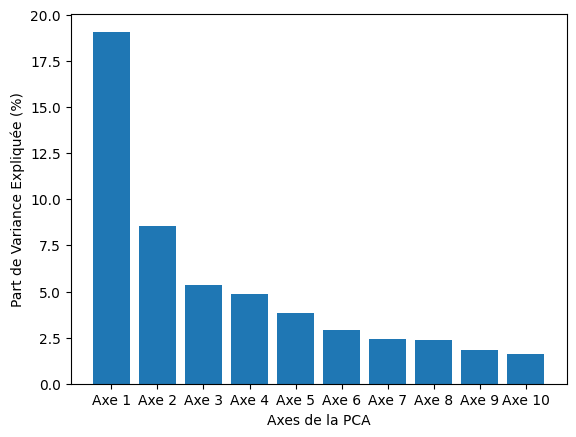

In [26]:
# Nb de composantes PCA retenues
pca = PCA(0.9)
X_train_pca = pca.fit_transform(X_train_extr_scaled)
print ("Nb de composantes PCA retenues :",pca.n_components_)

# Part de la variance expliquée des 10 premiers axes
import matplotlib.pyplot as plt
plt.bar([f"Axe {i+1}" for i in range(10)],pca.explained_variance_ratio_[:10] * 100)
plt.xlabel("Axes de la PCA")
plt.ylabel('Part de Variance Expliquée (%)')
plt.show()

Il a fallu **191 composantes** pour expliquer 90% de la variance des 2148 features. Sur le graphique on voit que le 1er axe explique un peu moins de 20% de la variance, le 2ème axe moins de 10%, etc.

Visualisons les **données projetées sur les 2 premiers axes**.

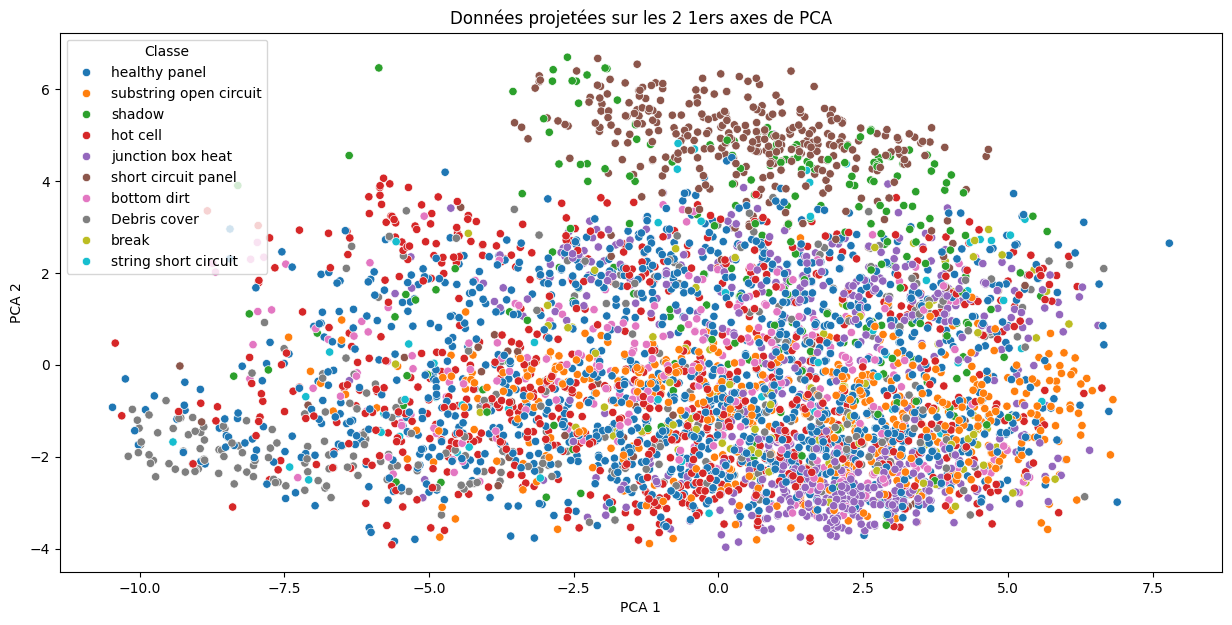

In [54]:
# Affichage des données projetées sur les 2 composantes principales
import seaborn as sns
plt.figure(figsize=(15,7))
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("Données projetées sur les 2 1ers axes de PCA")
plt.show()

Cette visualisation sur les 2 premiers axes de la PCA ne permet pas de dégager un schéma. Il y a peut-être 'short circuit panel' qui forme un cluster, mais ce n'est clairement pas marqué. Cela était prévisible, puisque que ces 2 axes expliquent seulement 27% environ de la variance.

Regardons maintenant la **contribution des features** aux 191 axes. Nous afficherons notamment, pour les 6 premiers axes, les 10 features qui contribuent le plus à la composante.

hog__HOG_1  hog__HOG_2  hog__HOG_3  hog__HOG_4  hog__HOG_5  hog__HOG_6  \
0      0.007273    0.000624   -0.003235   -0.001552    0.003554   -0.005929   
1     -0.008766   -0.000734    0.007677   -0.000566   -0.010064   -0.006046   
2     -0.001221    0.009660    0.015977    0.002549   -0.002964    0.002137   
3      0.000271    0.010311    0.011075    0.003805   -0.011729   -0.008373   
4     -0.029840   -0.014766   -0.016811   -0.010195   -0.023504   -0.003528   
..          ...         ...         ...         ...         ...         ...   
186   -0.002174    0.021875    0.032492    0.049208   -0.008103    0.032988   
187   -0.010934   -0.018594    0.000446   -0.010304   -0.012573   -0.025356   
188    0.029189   -0.011360   -0.020504   -0.013820   -0.024876   -0.043068   
189    0.023803    0.017397    0.023760    0.016762    0.005459    0.010590   
190   -0.003362   -0.017344   -0.041856   -0.037098   -0.024219    0.003543   

     hog__HOG_7  hog__HOG_8  hog__HOG_9  hog__HOG_10  hog__HOG_11  \
0     -0.006800   -0.005238    0.007245     0.001217    -0.002618   
1      0.002511    0.003380   -0.002737    -0.036029    -0.012193   
2      0.010419    0.011227    0.007305    -0.013464     0.001124   
3      0.001701    0.006598    0.008549     0.020126     0.016694   
4     -0.003671   -0.004224   -0.027904    -0.000938     0.010630   
..          ...         ...         ...          ...          ...   
186   -0.000662    0.020506   -0.042431     0.023726    -0.064332   
187   -0.013579   -0.019705   -0.012533    -0.013824    -0.025992   
188   -0.046461   -0.061364   -0.011424     0.042124     0.007329   
189   -0.007993   -0.006185    0.000688     0.017926     0.025195   
190    0.011720   -0.009687   -0.016253     0.039812     0.055265   

     hog__HOG_12  hog__HOG_13  hog__HOG_14  hog__HOG_15  hog__HOG_16  \
0      -0.003967    -0.003192    -0.000004    -0.005536    -0.004421   
1      -0.001801    -0.002482    -0.005986    -0.006582    -0.005997   
2       0.005830    -0.005207    -0.012408    -0.002930     0.006109   
3       0.003414    -0.013341    -0.027187    -0.004350     0.017068   
4      -0.007584    -0.010448    -0.014389     0.004176     0.006050   
..           ...          ...          ...          ...          ...   
186    -0.040122     0.037958    -0.001349     0.037996    -0.021766   
187    -0.064025    -0.026941    -0.024817    -0.021680    -0.017958   
188    -0.010840     0.018167    -0.006951    -0.029514    -0.036719   
189     0.018789    -0.000220    -0.004404    -0.004019    -0.025557   
190     0.033474    -0.026927    -0.022760    -0.026088    -0.011995   

     hog__HOG_17  hog__HOG_18  hog__HOG_19  hog__HOG_20  hog__HOG_21  \
0      -0.001371    -0.000362    -0.002598    -0.003403    -0.004803   
1      -0.010287    -0.010760    -0.040536    -0.030854    -0.020430   
2       0.005007     0.007479    -0.015059    -0.011750    -0.001967   
3       0.032909     0.045595    -0.014301    -0.009891    -0.009284   
4       0.025960     0.037587    -0.016578     0.005203    -0.001486   
..           ...          ...          ...          ...          ...   
186    -0.044241    -0.012023     0.011106    -0.028571    -0.016506   
187    -0.011165    -0.003869     0.017454    -0.007753    -0.003779   
188    -0.015753     0.007831     0.017856    -0.006951    -0.041619   
189    -0.051626    -0.045616     0.016547     0.030432     0.044446   
190     0.008919     0.030935    -0.000542     0.008803     0.031924   

     hog__HOG_22  hog__HOG_23  hog__HOG_24  hog__HOG_25  hog__HOG_26  \
0      -0.005463    -0.000769    -0.005397    -0.005366    -0.003860   
1      -0.019800    -0.009557    -0.019498    -0.020214    -0.023552   
2      -0.012801    -0.018415    -0.013556    -0.006593    -0.009357   
3      -0.013607    -0.018214    -0.012423    -0.004107    -0.005710   
4      -0.004137    -0.012408     0.000084     0.000408     0.006491   
..           ...          ...          ...          ...          

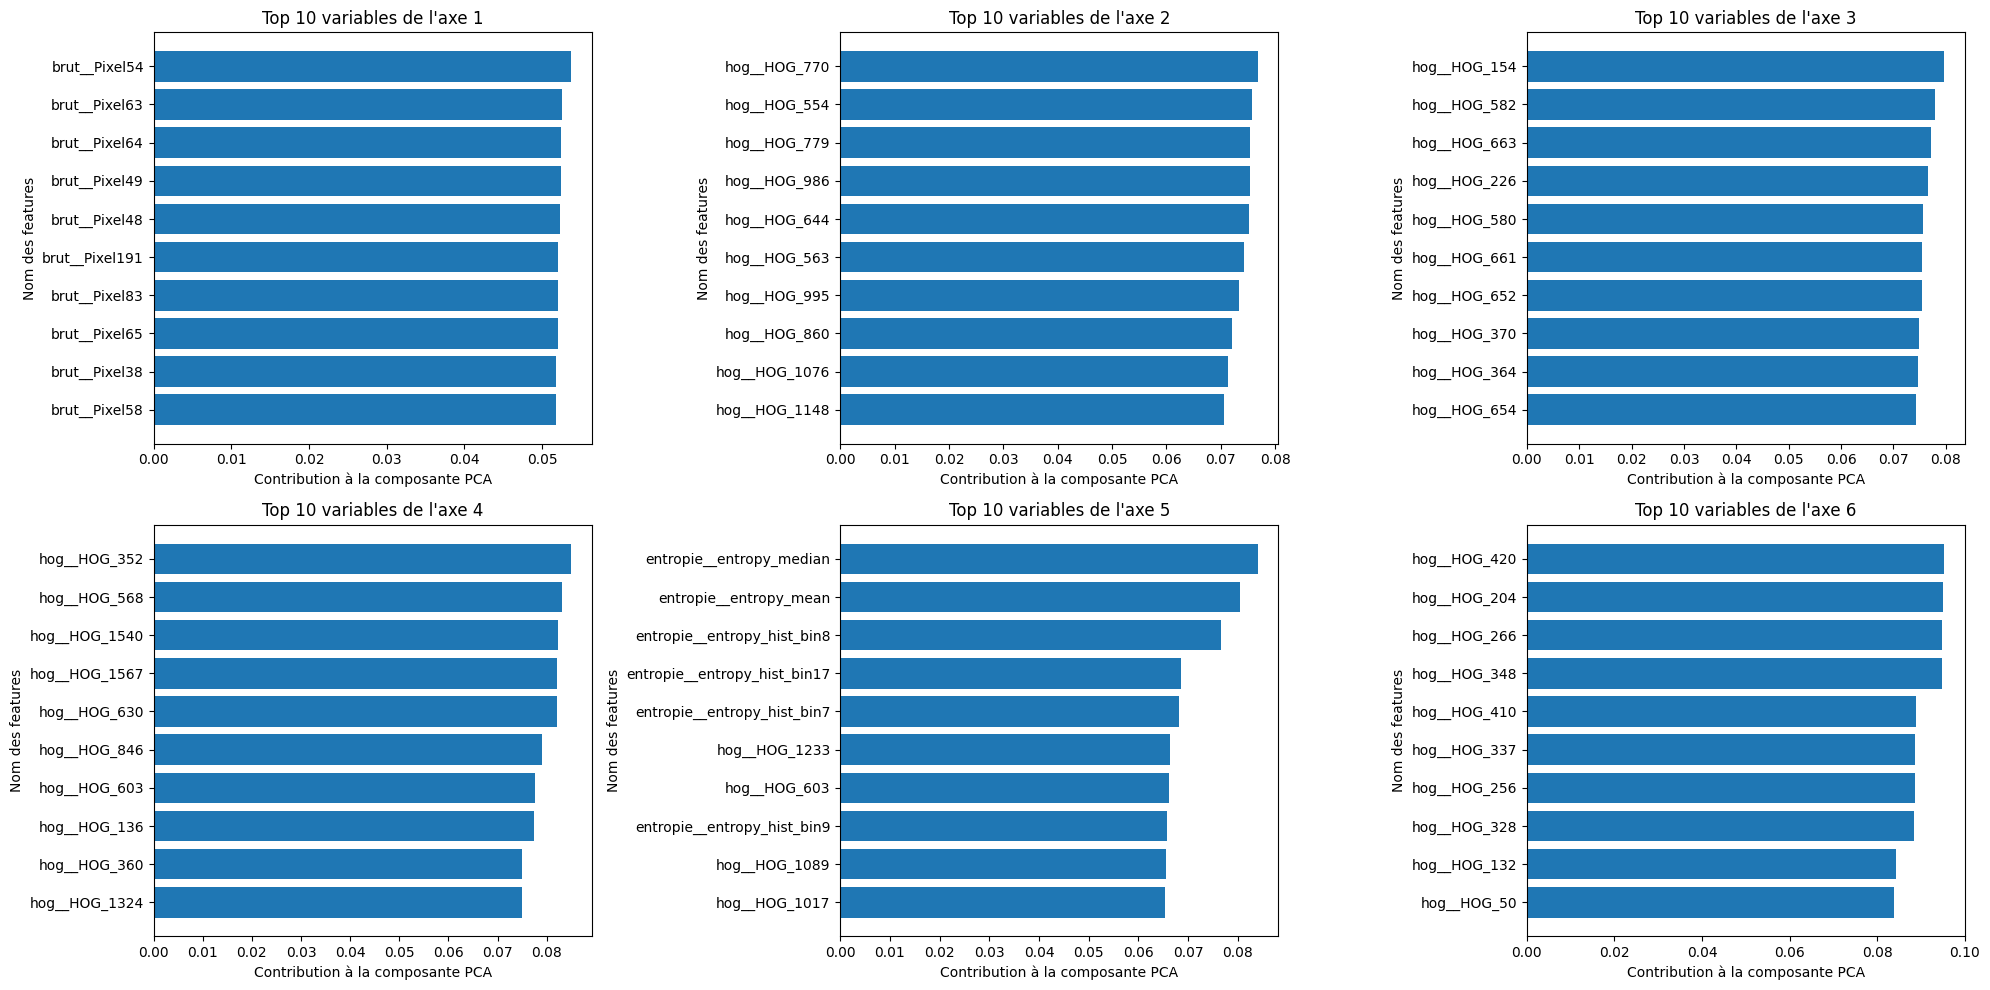

In [55]:
# Dataframe des (composantes,features)
df_corr_PCA_features = pd.DataFrame(pca.components_,columns=X_train_extr_scaled.columns)
display (df_corr_PCA_features)

# Affichage pour les 6 premières composantes
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    # Récupération des 10 features les plus importantes
    top_features = df_corr_PCA_features.iloc[i].abs().sort_values(ascending=False).head(10)
    # Barplot horizontal
    plt.barh(top_features.index,top_features.values)
    plt.gca().invert_yaxis()
    plt.xlabel("Contribution à la composante PCA")
    plt.ylabel("Nom des features")
    plt.title(f"Top 10 variables de l'axe {i+1}")
    plt.tight_layout()
plt.show()

On s'aperçoit que le premier axe de la PCA fait principalement appel aux pixels bruts. Par contre les 3 suivants utilisent les vecteurs HOG en priorité. On note la contribution importante de l'entropie sur le 5ème axe.

Le fait que les 3 groupes de features (pixels bruts, HOG, entropie) apparaissent sur les premières composantes de la PCA conforte l'idée que les extracteurs choisis en entrée de la pipeline fournissent des informations complémentaires et pertinentes pour notre modèle.

# 7. Optimisation du rééchantillonnage

Comme pour la section précédente, nous allons partir des données transformées suite aux 1ères étapes de la pipeline (extraction + mise à l'échelle).

In [37]:
X_train_extr_scaled = pd.read_csv(f"{results_dir}/X_train_extr_scaled.csv",index_col='index')

In [16]:
# GridSearch Réduction de dimension (figée) + Rééchantillonnage + SVM (figé)
param_grid = build_param_grid(default_steps,reduction="one",sampler="all",clf="one")
cv_results,pipeline_report = cross_validation(pipeline,param_grid,X_train_extr_scaled,y_train)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_clf  \
2      65.796177      1.165738         3.202936        0.411322  SVC(C=10)   
5      63.297533      0.471013         2.750227        0.262958  SVC(C=10)   
1      62.325560      1.909095         3.075524        0.167322  SVC(C=10)   
0      58.241043      0.252558         1.458280        0.036085  SVC(C=10)   
7      44.456552      1.060752         0.956362        0.208599  SVC(C=10)   
6      51.969284      2.131039         1.296402        0.653866  SVC(C=10)   
4      47.560252      0.362443         0.257122        0.075083  SVC(C=10)   
3      44.199231      4.791036         0.233382        0.030797  SVC(C=10)   

  param_features        param_reduction         param_sampler param_scaler  \
2    passthrough  PCA(n_components=0.9)              ADASYN()  passthrough   
5    passthrough  PCA(n_components=0.9)          SMOTETomek()  passthrough   
1    passthrough  PCA(n_components=0.9)               SMOTE()  passthrough   
0    passthrough  PCA(n_components=0.9)   RandomOverSampler()  passthrough   
7    passthrough  PCA(n_components=0.9)           passthrough  passthrough   
6    passthrough  PCA(n_components=0.9)            SMOTEENN()  passthrough   
4    passthrough  PCA(n_components=0.9)    ClusterCentroids()  passthrough   
3    passthrough  PCA(n_components=0.9)  RandomUnderSampler()  passthrough   

                                              params  split0_test_accuracy  \
2  {'clf': SVC(C=10), 'features': 'passthrough', ...              0.840807   
5  {'clf': SVC(C=10), 'features': 'passthrough', ...              0.837444   
1  {'clf': SVC(C=10), 'features': 'passthrough', ...              0.836323   
0  {'clf': SVC(C=10), 'features': 'passthrough', ...              0.834081   
7  {'clf': SVC(C=10), 'features': 'passthrough', ...              0.835202   
6  {'clf': SVC(C=10), 'features': 'passthrough', ...              0.697309   
4  {'clf': SVC(C=10), 'features': 'passthrough', ...              0.626682   
3  {'clf': SVC(C=10), 'features': 'passthrough', ...              0.625561   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
2              0.803812              0.812570              0.838384   
5              0.804933              0.808081              0.843996   
1              0.809417              0.811448              0.833895   
0              0.804933              0.804714              0.837262   
7              0.802691              0.804714              0.840629   
6              0.678251              0.701459              0.685746   
4              0.640135              0.658810              0.658810   
3              0.643498              0.604938              0.652076   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
2              0.817059            0.822526           0.014594   
5              0.814815            0.821854           0.015867   
1              0.818182            0.821853           0.011232   
0              0.814815            0.819161           0.014002   
7              0.819304            0.820508           0.015421   
6              0.676768            0.687907           0.009940   
4              0.621773            0.641242           0.015553   
3              0.618406            0.628896           0.017004   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
2                   1              0.809619              0.717055   
5                   2              0.804057              0.718869   
1                   3              0.806079              0.720741   
0                   5              0.797326              0.707085   
7                   4              0.797481              0.702801   
6                   6              0.714513              0.648345   
4                   7              0.610472              0.609575   
3                   8              0.611411              0.620827   

   split2_test_f1_macro  split3_test_

Best params (f1 macro) :  {'clf': SVC(C=10), 'features': 'passthrough', 'reduction': PCA(n_components=0.9), 'sampler': ADASYN(), 'scaler': 'passthrough'}
Best score (f1 macro):  0.7638246181451132


In [ ]:
# Sauvegarde du dataframe dans un CSV
cv_results.to_csv(f"{results_dir}/cv_results_sampler.csv",index=False)

### Choix de la meilleure combinaison

In [23]:
import plotly.express as px

# Extraction d'un dataframe à partir de cv_results pour affichage
plot_results = cv_results.copy()[['param_sampler','mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time']]
plot_results['param_sampler'] = plot_results['param_sampler'].astype(str)
# Mise en évidence de la pipeline choisie (a posteriori)
plot_results["highlight"] = plot_results['param_sampler'] == "passthrough"

# Affichage pour chaque pipeline de son accuracy et de son temps d'entraînement moyen en validation croisée
fig=px.scatter(plot_results,x='mean_fit_time',y='mean_test_accuracy',size='std_test_accuracy',color="highlight",
               hover_name='param_sampler',
               hover_data=['mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time'])
fig.update_layout(title="Accuracy vs temps d'entraînement des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

In [24]:
# Affichage pour chaque pipeline de son f1-score (macro) et de son temps de prédiction moyen en validation croisée
fig=px.scatter(plot_results,x='mean_score_time',y='mean_test_f1_macro',size='std_test_f1_macro',color='highlight',
               hover_name='param_sampler',
               hover_data=['mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time'])
fig.update_layout(title="F1-score vs temps de prédiction des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

Au vu de ces résultats, nous choisissons de **ne pas appliquer de rééchantillonnage** (en rouge sur le graphe).

Certaines techniques de sur-échantillonnage permettent d'augmenter très légèrement le f1-score (jusqu'à 0.5%) mais pour un temps d'entraînement 50% plus important environ. Leur intérêt est donc bien limité.

### => On fige l'absence de rééchantillonnage

In [25]:
# On met à jour l'étape de rééchantillonnage par défaut de la pipeline
default_steps['sampler']="passthrough"

# 8. Evaluation de la pipeline

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Fonction d'évaluation d'une pipeline fittée     
def evaluate_pipeline(fitted_pipe,X_test,y_test):
    # Affichage pipeline
    display(fitted_pipe)
    # Prédiction
    y_pred = fitted_pipe.predict(X_test)
    # Matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies classes")
    plt.title("Matrice de confusion")
    plt.show()
    # Rapport de classification
    class_report = classification_report(y_test, y_pred)
    print("Rapport de classification :\n", class_report)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('hog',
                                                 HOGExtractor(cells_per_block=(3,
                                                                               3),
                                                              pixels_per_cell=(12,
                                                                               12))),
                                                ('glcm', 'drop'),
                                                ('entropie',
                                                 EntropyExtractor(bins=20)),
                                                ('canny', 'drop'),
                                                ('brut',
                                                 PixelsBrutsExtractor(image_size=(15,
                                                                                  28)))])),
                ('scaler', MinMaxScaler()),
                ('reduction', PCA(n_components=0.9)),
                ('sampler', 'passthrough'), ('clf', SVC(C=10))])

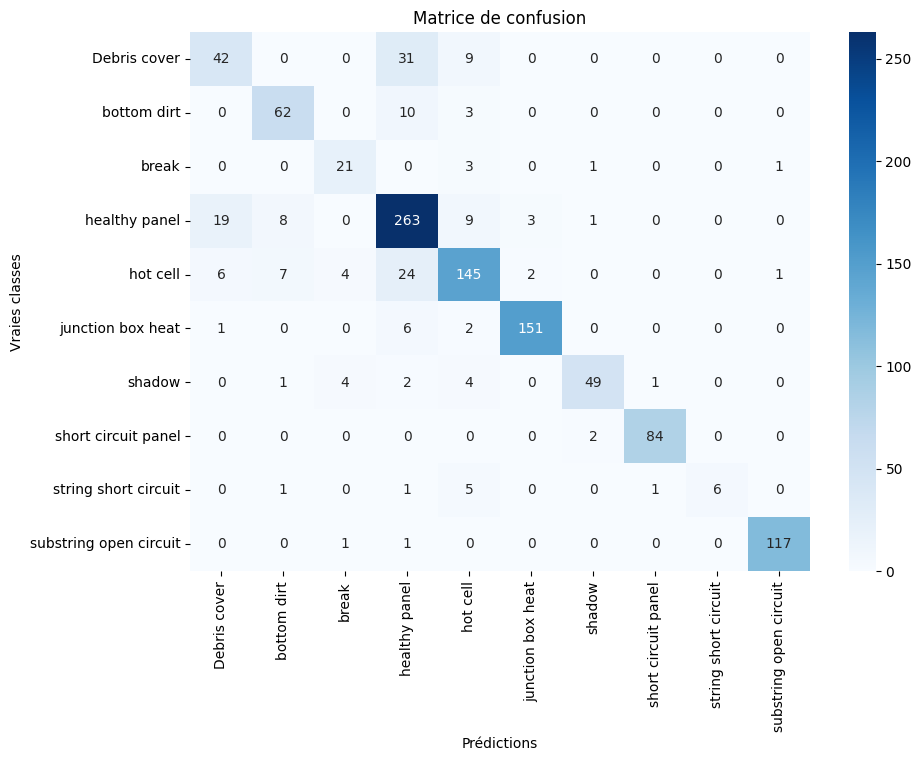

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.62      0.51      0.56        82
           bottom dirt       0.78      0.83      0.81        75
                 break       0.70      0.81      0.75        26
         healthy panel       0.78      0.87      0.82       303
              hot cell       0.81      0.77      0.79       189
     junction box heat       0.97      0.94      0.96       160
                shadow       0.92      0.80      0.86        61
   short circuit panel       0.98      0.98      0.98        86
  string short circuit       1.00      0.43      0.60        14
substring open circuit       0.98      0.98      0.98       119

              accuracy                           0.84      1115
             macro avg       0.85      0.79      0.81      1115
          weighted avg       0.84      0.84      0.84      1115



In [13]:
# Pipeline finale = extraction des features HOG/entropie/pixels bruts + MinMaxScaler + PCA(0.9) + SVM(C=10)
default_steps['hog']= HOGExtractor(image_size=(60,110),pixels_per_cell=(12,12),cells_per_block=(3,3))
default_steps['glcm']= 'drop'
default_steps['entropie'] = EntropyExtractor(image_size=(60,110),radius=4, bins=20, include_histogram=True)
default_steps['canny'] = 'drop'
default_steps['brut'] = PixelsBrutsExtractor(image_size=(15,28))
default_steps['scaler']= MinMaxScaler()
default_steps['reduction']= PCA(0.9)
default_steps['sampler']= "passthrough"
default_steps['clf'] = SVC(C=10,kernel="rbf",gamma="scale")

my_pipeline = ImbPipeline([
    ('features', FeatureUnion([
        ('hog', default_steps['hog']),
        ('glcm', default_steps['glcm']),
        ('entropie',default_steps['entropie']),
        ('canny',default_steps['canny']),
        ('brut',default_steps['brut'])
    ])),
    ('scaler', default_steps['scaler']),
    ('reduction', default_steps['reduction']),
    ('sampler', default_steps['sampler']),
    ('clf', default_steps['clf'])
])

# Entraînement sur train et évaluation sur test
my_pipeline.fit(X_train,y_train)
evaluate_pipeline(my_pipeline,X_test,y_test)

On a une **bonne généralisation : 84% d'accuracy et 81% de f1-score**. Un peu plus de difficulté dans la détection des défauts de type  : 
- "Debris cover" => souvent confondus avec "Healthy Panel"
- "String short circuit" (classe peu représentée dans le dataset) => la moité sont prédits en "Hot cell" 
- Quelques erreurs sur la classification des défauts "Break", "Hot cell" et "Bottom dirt"

### Avec retrait des images carrées mises en doute...

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('hog',
                                                 HOGExtractor(cells_per_block=(3,
                                                                               3),
                                                              pixels_per_cell=(12,
                                                                               12))),
                                                ('glcm', 'drop'),
                                                ('entropie',
                                                 EntropyExtractor(bins=20)),
                                                ('canny', 'drop'),
                                                ('brut',
                                                 PixelsBrutsExtractor(image_size=(15,
                                                                                  28)))])),
                ('scaler', MinMaxScaler()),
                ('reduction', PCA(n_components=0.9)),
                ('sampler', 'passthrough'), ('clf', SVC(C=10))])

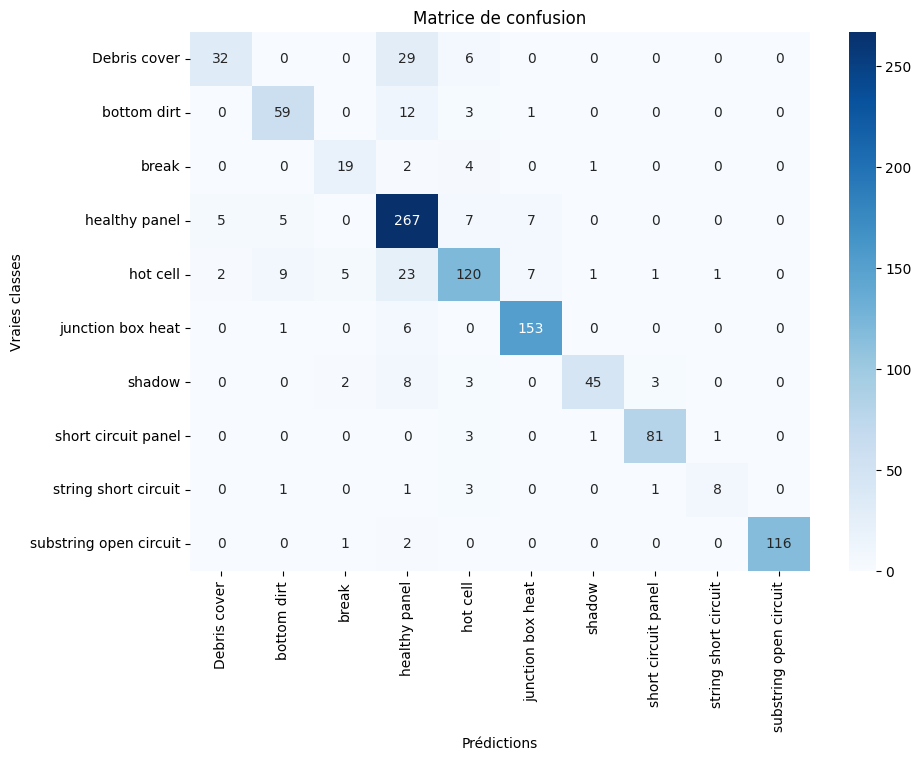

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.82      0.48      0.60        67
           bottom dirt       0.79      0.79      0.79        75
                 break       0.70      0.73      0.72        26
         healthy panel       0.76      0.92      0.83       291
              hot cell       0.81      0.71      0.75       169
     junction box heat       0.91      0.96      0.93       160
                shadow       0.94      0.74      0.83        61
   short circuit panel       0.94      0.94      0.94        86
  string short circuit       0.80      0.57      0.67        14
substring open circuit       1.00      0.97      0.99       119

              accuracy                           0.84      1068
             macro avg       0.85      0.78      0.80      1068
          weighted avg       0.85      0.84      0.84      1068



In [14]:
# Découpage train/test avec retrait des images carrées
X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="110x60",removeCarre=True)

# Entraînement sur train et évaluation sur test
my_pipeline.fit(X_train,y_train)
evaluate_pipeline(my_pipeline,X_test,y_test)

Suite au retrait des images carrées, les f1-score peuvent varier légèrement sur les différentes classes mais la performance reste similaire au global.

### Avec le découpage proposé par les constructeurs du dataset...

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('hog',
                                                 HOGExtractor(cells_per_block=(3,
                                                                               3),
                                                              pixels_per_cell=(12,
                                                                               12))),
                                                ('glcm', 'drop'),
                                                ('entropie',
                                                 EntropyExtractor(bins=20)),
                                                ('canny', 'drop'),
                                                ('brut',
                                                 PixelsBrutsExtractor(image_size=(15,
                                                                                  28)))])),
                ('scaler', MinMaxScaler()),
                ('reduction', PCA(n_components=0.9)),
                ('sampler', 'passthrough'), ('clf', SVC(C=10))])

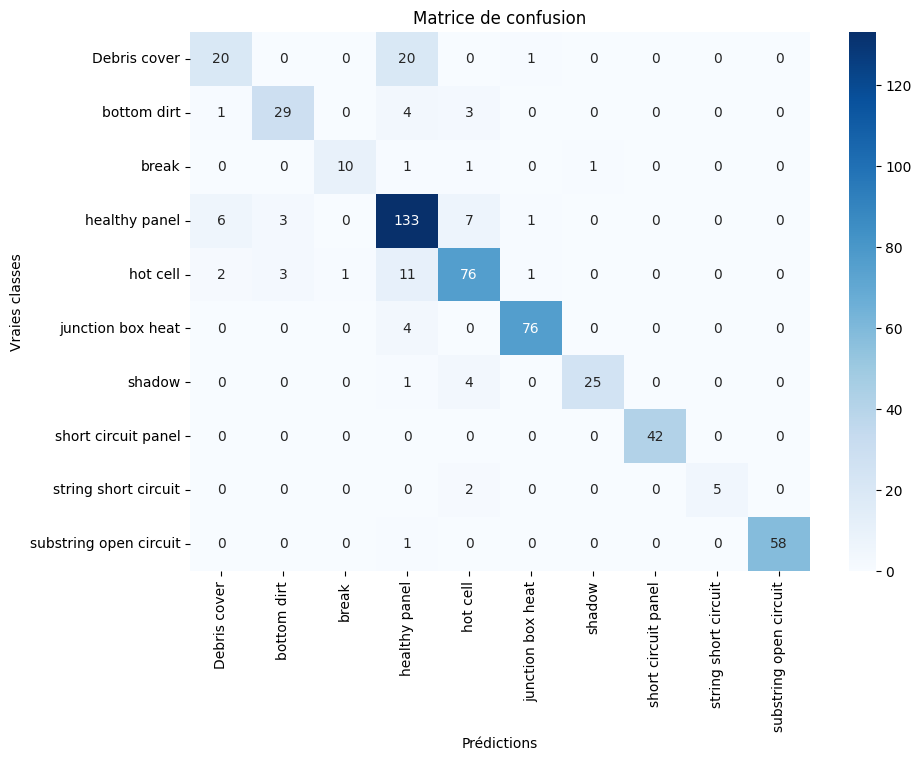

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.69      0.49      0.57        41
           bottom dirt       0.83      0.78      0.81        37
                 break       0.91      0.77      0.83        13
         healthy panel       0.76      0.89      0.82       150
              hot cell       0.82      0.81      0.81        94
     junction box heat       0.96      0.95      0.96        80
                shadow       0.96      0.83      0.89        30
   short circuit panel       1.00      1.00      1.00        42
  string short circuit       1.00      0.71      0.83         7
substring open circuit       1.00      0.98      0.99        59

              accuracy                           0.86       553
             macro avg       0.89      0.82      0.85       553
          weighted avg       0.86      0.86      0.86       553



In [15]:
# Découpage train / test proposé par les constructeurs du dataset
X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="110x60",originalTrainTest=True)

# Entraînement sur train et évaluation sur test
my_pipeline.fit(X_train,y_train)
evaluate_pipeline(my_pipeline,X_test,y_test)

Avec le découpage proposé par les constructeurs du dataset (90% / 10%), on améliore les résultats : **86% d'accuracy et 85% de f1-score**. Pour rappel dans leur article de recherche, le meilleur score atteint avec des modèles de Deep Learning pour les images 110x60 était de 92% d'accuracy et 91% de f1-score.

### Avec le format d'images original (avant recadrage / découpage en 110x60)...

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('hog',
                                                 HOGExtractor(cells_per_block=(3,
                                                                               3),
                                                              pixels_per_cell=(12,
                                                                               12))),
                                                ('glcm', 'drop'),
                                                ('entropie',
                                                 EntropyExtractor(bins=20)),
                                                ('canny', 'drop'),
                                                ('brut',
                                                 PixelsBrutsExtractor(image_size=(15,
                                                                                  28)))])),
                ('scaler', MinMaxScaler()),
                ('reduction', PCA(n_components=0.9)),
                ('sampler', 'passthrough'), ('clf', SVC(C=10))])

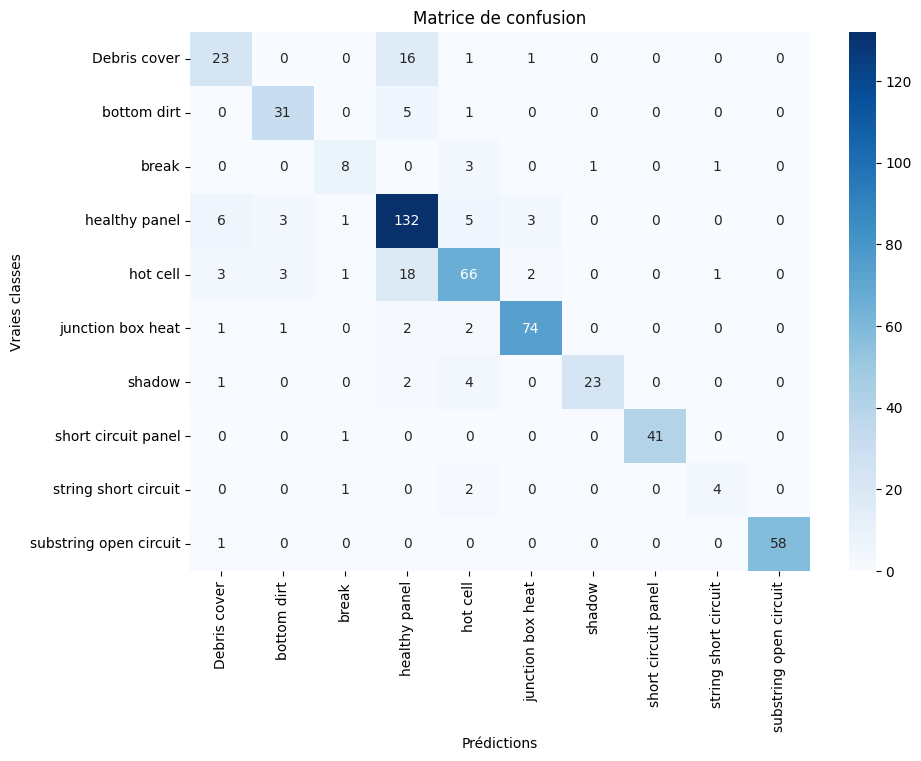

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.66      0.56      0.61        41
           bottom dirt       0.82      0.84      0.83        37
                 break       0.67      0.62      0.64        13
         healthy panel       0.75      0.88      0.81       150
              hot cell       0.79      0.70      0.74        94
     junction box heat       0.93      0.93      0.93        80
                shadow       0.96      0.77      0.85        30
   short circuit panel       1.00      0.98      0.99        42
  string short circuit       0.67      0.57      0.62         7
substring open circuit       1.00      0.98      0.99        59

              accuracy                           0.83       553
             macro avg       0.82      0.78      0.80       553
          weighted avg       0.83      0.83      0.83       553



In [16]:
# Découpage train / test proposé par les constructeurs du dataset sur les images originales
X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="Ori",originalTrainTest=True)

# Entraînement sur train et évaluation sur test
my_pipeline.fit(X_train,y_train)
evaluate_pipeline(my_pipeline,X_test,y_test)

On constate sans surprise une baisse des résultats par rapport au format 110x60, mais cela reste tout-à-fait honorable : 83% d'accuracy et 80% de f1-score. Notre modèle détecte bien la plupart des défauts sur les images non traitées.

# 9. Interprétabilité

Le classifieur SVM avec un noyau non linéaire et la PCA ne permettent pas une interprétabilité spécifique. Nous devons faire appel à une interprétabilité agnostique.

On récupère les données d'entrée après extraction des features.

Nous allons étudier l'interprétabilité de ces données lors des étapes finales de la pipeline (scaler + PCA + SVM).

In [15]:
# Pour l'interprétabilité, il nous faudra extraire les scores de probabilité attribués à chaque classe par SVM
# On modifie donc l'étape de classifieur de la pipeline en ajoutant le paramètre probability=True
interp_pipeline = ImbPipeline([
    ('features', FeatureUnion([
        ('hog', HOGExtractor(image_size=(60,110),pixels_per_cell=(12,12),cells_per_block=(3,3))),
        ('entropie',EntropyExtractor(image_size=(60,110),radius=4, bins=20, include_histogram=True)),
        ('brut',PixelsBrutsExtractor(image_size=(15,28)))
    ])),
    ('scaler', MinMaxScaler()),
    ('reduction', PCA(0.9)),
    ('clf', SVC(kernel="rbf", gamma="scale",C=10,probability=True))
])

# Découpage train / test par défaut et entraînement
X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="110x60")
interp_pipeline.fit(X_train,y_train)
y_pred = interp_pipeline.predict(X_test)
y_pred_proba = interp_pipeline.predict_proba(X_test)

# On récupère l'ensemble train après extraction des features
start_pipe = interp_pipeline[0]
X_train_transformed = start_pipe.transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed,index = X_train.index,columns=start_pipe.get_feature_names_out())
display (X_train_transformed)

# On récupère l'ensemble test après extraction des features
X_test_transformed = start_pipe.transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed,index = X_test.index,columns=start_pipe.get_feature_names_out())
display (X_test_transformed)

# On récupère les étapes finales de la pipeline (à partir du scaling)
end_pipe = interp_pipeline[1:]


hog__HOG_1  hog__HOG_2  hog__HOG_3  hog__HOG_4  hog__HOG_5  hog__HOG_6  \
5277    0.254922    0.251270    0.191820    0.197618    0.254922    0.004607   
3825    0.273779    0.152170    0.119427    0.089624    0.062835    0.032970   
3171    0.102014    0.022783    0.050980    0.023777    0.098576    0.032915   
2697    0.257100    0.147591    0.075157    0.200322    0.257100    0.257100   
1610    0.231961    0.179485    0.127561    0.072415    0.202101    0.014437   
...          ...         ...         ...         ...         ...         ...   
2136    0.259454    0.147712    0.057641    0.032719    0.237621    0.117869   
5554    0.214082    0.012725    0.041704    0.116746    0.143199    0.066145   
709     0.070936    0.009743    0.032638    0.345612    0.456727    0.102879   
4055    0.079005    0.064675    0.084522    0.124433    0.106434    0.067795   
4511    0.266562    0.075067    0.072761    0.070702    0.247521    0.024207   

      hog__HOG_7  hog__HOG_8  hog__HOG_9  hog__HOG_10  hog__HOG_11  \
5277    0.011656    0.009214    0.217234     0.173744     0.051863   
3825    0.010523    0.021127    0.039100     0.114662     0.041510   
3171    0.078920    0.019953    0.016603     0.101756     0.027064   
2697    0.030162    0.102795    0.113036     0.257100     0.015724   
1610    0.015888    0.030456    0.056949     0.144262     0.059133   
...          ...         ...         ...          ...          ...   
2136    0.041371    0.158940    0.259454     0.109702     0.011825   
5554    0.055445    0.005522    0.006886     0.112482     0.014507   
709     0.013761    0.030663    0.003486     0.100215     0.000000   
4055    0.027007    0.038974    0.012374     0.061822     0.005423   
4511    0.020001    0.018897    0.266562     0.138864     0.029996   

      hog__HOG_12  hog__HOG_13  hog__HOG_14  hog__HOG_15  hog__HOG_16  \
5277     0.073343     0.053706     0.059752     0.049170     0.052450   
3825     0.116635     0.154203     0.026982     0.022536     0.056298   
3171     0.046206     0.087602     0.108303     0.076440     0.038724   
2697     0.155089     0.069490     0.257100     0.257100     0.066706   
1610     0.069713     0.092298     0.153138     0.043296     0.030178   
...           ...          ...          ...          ...          ...   
2136     0.019550     0.067262     0.188002     0.115360     0.048997   
5554     0.045207     0.090681     0.401012     0.072272     0.028318   
709      0.001355     0.148910     0.456727     0.239896     0.039015   
4055     0.047728     0.121326     0.282763     0.165241     0.013805   
4511     0.042296     0.074166     0.155828     0.051735     0.086667   

      hog__HOG_17  hog__HOG_18  hog__HOG_19  hog__HOG_20  hog__HOG_21  \
5277     0.018429     0.000000     0.150411     0.018429     0.042395   
3825     0.190426     0.150902     0.072013     0.041174     0.047162   
3171     0.031997     0.013111     0.116323     0.027064     0.053174   
2697     0.029417     0.000000     0.173835     0.047172     0.076907   
1610     0.025559     0.020177     0.231961     0.155173     0.231961   
...           ...          ...          ...          ...          ...   
2136     0.012313     0.019684     0.157310     0.048626     0.048509   
5554     0.002114     0.000000     0.058758     0.002114     0.041781   
709      0.002142     0.000000     0.093040     0.006666     0.007878   
4055     0.000000     0.000000     0.045553     0.000000     0.035734   
4511     0.017344     0.019098     0.200719     0.068214     0.071945   

      hog__HOG_22  hog__HOG_23  hog__HOG_24  hog__HOG_25  hog__HOG_26  \
5277     0.028761     0.090659     0.029552     0.062793     0.039680   
3825     0.092976     0.095076     0.157926     0.104374     0.062865   
3171     0.041498     0.109819     0.090547     0.035976     0.015020   
2697     0.079159     0.157241     0.096231     0.076571     0.048351   
1610     0.218176     0.091014     0.225735     0.231961     0.200889   
...         

hog__HOG_1  hog__HOG_2  hog__HOG_3  hog__HOG_4  hog__HOG_5  hog__HOG_6  \
4376    0.311089    0.173841    0.078559    0.091016    0.311089    0.050863   
2109    0.172548    0.034038    0.249370    0.230395    0.237331    0.140284   
4508    0.293976    0.061403    0.029898    0.232809    0.293976    0.133434   
3203    0.165317    0.073168    0.055647    0.028814    0.259579    0.050476   
1246    0.274031    0.098241    0.079443    0.088094    0.274031    0.085948   
...          ...         ...         ...         ...         ...         ...   
1382    0.283497    0.085291    0.038465    0.069343    0.234977    0.025992   
3699    0.263554    0.126758    0.099456    0.094262    0.210506    0.017616   
2222    0.256472    0.168194    0.055209    0.116308    0.256472    0.096934   
4119    0.244677    0.100782    0.052200    0.175664    0.244677    0.029534   
1401    0.282708    0.048129    0.065301    0.053948    0.282708    0.061953   

      hog__HOG_7  hog__HOG_8  hog__HOG_9  hog__HOG_10  hog__HOG_11  \
4376    0.028057    0.003398    0.233433     0.112859     0.004785   
2109    0.101976    0.059134    0.052173     0.078379     0.022383   
4508    0.023212    0.029377    0.202183     0.237140     0.000000   
3203    0.049614    0.023912    0.030969     0.130904     0.051809   
1246    0.071862    0.073551    0.014802     0.171477     0.028716   
...          ...         ...         ...          ...          ...   
1382    0.028420    0.015069    0.283497     0.206392     0.027193   
3699    0.004171    0.014126    0.058494     0.196977     0.008072   
2222    0.018522    0.074124    0.147495     0.100353     0.019737   
4119    0.002355    0.000000    0.023554     0.023317     0.003724   
1401    0.034307    0.044227    0.282708     0.105144     0.099090   

      hog__HOG_12  hog__HOG_13  hog__HOG_14  hog__HOG_15  hog__HOG_16  \
4376     0.011549     0.078408     0.311089     0.089142     0.028476   
2109     0.015707     0.041442     0.249370     0.249370     0.111922   
4508     0.015345     0.177446     0.293976     0.119905     0.003216   
3203     0.087265     0.021257     0.090675     0.081032     0.035890   
1246     0.067357     0.205818     0.274031     0.125228     0.051476   
...           ...          ...          ...          ...          ...   
1382     0.062124     0.094736     0.099245     0.046222     0.042198   
3699     0.030094     0.057702     0.216694     0.095861     0.118876   
2222     0.077002     0.081881     0.233435     0.101463     0.061383   
4119     0.027436     0.244677     0.244677     0.015359     0.002355   
1401     0.120383     0.126720     0.084161     0.027225     0.031431   

      hog__HOG_17  hog__HOG_18  hog__HOG_19  hog__HOG_20  hog__HOG_21  \
4376     0.007316     0.007874     0.084076     0.004376     0.002149   
2109     0.036528     0.030992     0.127433     0.052145     0.078409   
4508     0.005855     0.007192     0.213190     0.045148     0.040988   
3203     0.037237     0.018747     0.080273     0.042147     0.077069   
1246     0.025981     0.028392     0.130162     0.055970     0.029715   
...           ...          ...          ...          ...          ...   
1382     0.027449     0.009166     0.229372     0.048686     0.111326   
3699     0.130462     0.263554     0.090889     0.010156     0.007370   
2222     0.021265     0.003556     0.137794     0.058832     0.043392   
4119     0.000000     0.000000     0.019986     0.000000     0.077333   
1401     0.012089     0.027692     0.102666     0.032907     0.041126   

      hog__HOG_22  hog__HOG_23  hog__HOG_24  hog__HOG_25  hog__HOG_26  \
4376     0.037343     0.311089     0.061929     0.011725     0.005663   
2109     0.227873     0.249370     0.249370     0.161821     0.052507   
4508     0.117372     0.293976     0.142281     0.028904     0.015953   
3203     0.067347     0.109849     0.090258     0.042098     0.032601   
1246     0.058631     0.260451     0.157453     0.075193     0.033101   
...         

Même avec un échantillon limité, SHAP en mode KernelExplainer est beaucoup trop coûteux en calcul, étant donné le nombre de features que nous avons (plus de 2000). Nous utiliserons donc **LIME**. Par conséquent, il s'agira d'une interprétabilité locale et approximative.

In [16]:
import lime
import lime.lime_tabular

# On construit l'explainer LIME à partir de l'ensemble d'entraînement (transformé)
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_transformed.to_numpy(),
    training_labels=y_train,
    mode='classification',
    feature_names=X_train_transformed.columns,
    class_names=end_pipe.classes_,
    random_state=42
)

### Explication d'une instance où le modèle s'est trompé

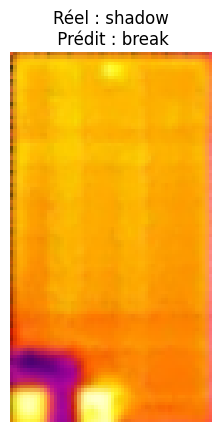

In [17]:
# On choisit une instance de test à expliquer
instance_idx = 7
img = cv2.imread(X_test.iloc[instance_idx]["Chemin"])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Réel : {y_test.iloc[instance_idx]}\n Prédit : {y_pred[instance_idx]}")
plt.show()

On va essayer de voir pourquoi on le modèle prédit la classe Break plutôt que Shadow sur cette image

In [18]:
predicted_class_idx = end_pipe.classes_.tolist().index("break")
real_class_idx = end_pipe.classes_.tolist().index("shadow")
print (f"Probabilité prédiction classe break : {y_pred_proba[instance_idx][predicted_class_idx]}")
print (f"Proba prédiction classe shadow (réel) : {y_pred_proba[instance_idx][real_class_idx]}")

Probabilité prédiction classe break : 0.49722965086630005
Proba prédiction classe shadow (réel) : 0.10879023803807396


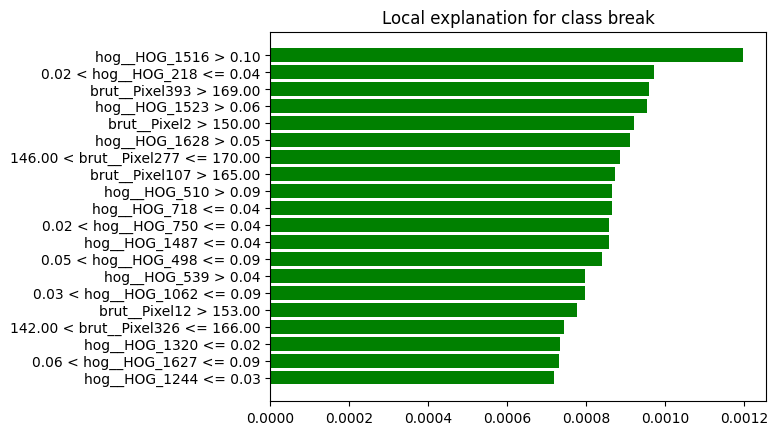

In [28]:
# Générer l'explication sur l'instance de test choisie (transformée)
explanation = explainer.explain_instance(
    data_row=X_test_transformed.iloc[instance_idx].to_numpy(),
    predict_fn= end_pipe.predict_proba,
    num_features=20,
    labels=np.arange(len(end_pipe.classes_))
)

# Afficher l'explication sous forme de graphique pour la classe prédite
fig = explanation.as_pyplot_figure(label=predicted_class_idx)
plt.show()

# ATTENTION L'EXPLICATION LIME VARIE A CHAQUE EXECUTION !!

On voit que à la fois les vecteurs HOG et les pixels bruts contribuent à la prédiction de cette image en classe Break.

Regardons également quelles features ont été utilisées par notre modèle pour inférer que l'image en question n'est PAS une classe SHADOW

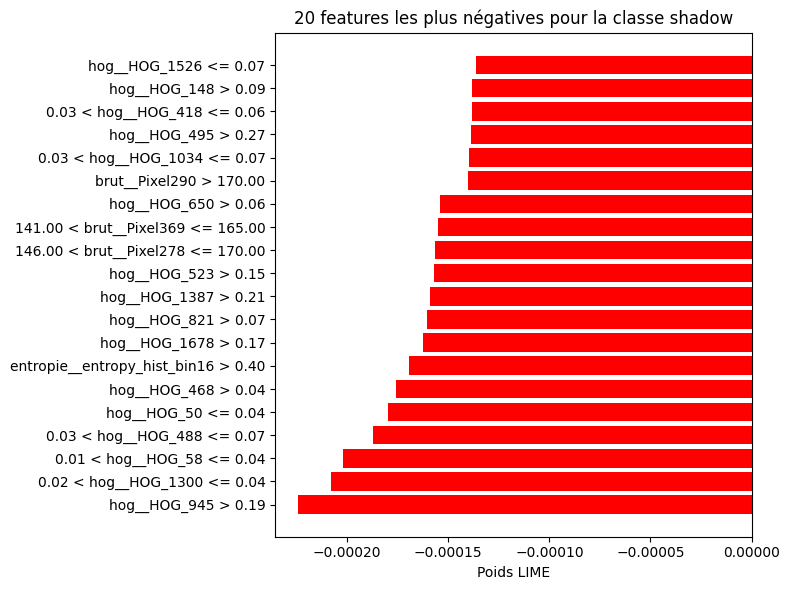

In [29]:
# Générer l'explication sur l'instance de test choisie (transformée)
explanation = explainer.explain_instance(
    data_row=X_test_transformed.iloc[instance_idx].to_numpy(),
    predict_fn= end_pipe.predict_proba,
    num_features=X_test_transformed.shape[1],
    labels=[real_class_idx])

# On récupère la liste des (feature_name, weight)
feature_weights = explanation.as_list(label=real_class_idx)

# On filtre les poids négatifs uniquement et trie par poids croissant
negative_features = sorted(
    [(feat, w) for feat, w in feature_weights if w < 0], 
    key=lambda x: x[1]
)[:20] # on récupère les features avec les 20 poids les plus négatifs 

# Séparer noms et poids
features, weights = zip(*negative_features)

# Affichage
plt.figure(figsize=(8, 6))
plt.barh(features, weights, color='red')
plt.xlabel('Poids LIME')
plt.title(f'20 features les plus négatives pour la classe {end_pipe.classes_[real_class_idx]}')
plt.tight_layout()
plt.show()

Ce sont principalement des vecteurs HOG (donc des gradients) qui figurent parmi les 20 contributions les plus importantes au rejet de la classe Shadow.


**Visualisons les cellules HOG** correspondant aux :
- 5 features HOG les plus importantes pour la prédiction de la classe Break
- 5 features HOG les plus importantes pour le rejet de la classe Shadow

In [ ]:
# Fonction de décodage des infos HOG correspondant à une feature HOG:
# - localisation du bloc de normalisation
# - localisation de la cellule HOG (dans le bloc et en absolu)
# - orientation du gradient
def decode_hog_index(index, 
                     image_shape=(110, 60), 
                     pixels_per_cell=(12, 12), 
                     cells_per_block=(3, 3), 
                     orientations=9):

    n_cells_y = image_shape[0] // pixels_per_cell[0]  # vertical
    n_cells_x = image_shape[1] // pixels_per_cell[1]  # horizontal

    n_blocks_y = n_cells_y - cells_per_block[0] + 1
    n_blocks_x = n_cells_x - cells_per_block[1] + 1

    values_per_block = orientations * cells_per_block[0] * cells_per_block[1]

    # Étape 1 : bloc et position locale
    block_idx = index // values_per_block
    index_in_block = index % values_per_block

    cell_in_block_idx = index_in_block // orientations
    orientation_idx = index_in_block % orientations

    row_in_block = cell_in_block_idx // cells_per_block[1]
    col_in_block = cell_in_block_idx % cells_per_block[1]

    # Étape 2 : position du bloc dans l’image
    block_row = block_idx // n_blocks_x
    block_col = block_idx % n_blocks_x

    # Étape 3 : position absolue de la cellule dans l’image (en indices de cellule)
    cell_row_abs = block_row + row_in_block
    cell_col_abs = block_col + col_in_block

    # Étape 4 : position en pixels de la cellule
    pixel_top = cell_row_abs * pixels_per_cell[0]
    pixel_bottom = (cell_row_abs + 1) * pixels_per_cell[0] - 1

    pixel_left = cell_col_abs * pixels_per_cell[1]
    pixel_right = (cell_col_abs + 1) * pixels_per_cell[1] - 1

    return {
        "block_index": block_idx,
        "block_position": (block_row, block_col),
        "cell_in_block": (row_in_block, col_in_block),
        "cell_absolute": (cell_row_abs, cell_col_abs),
        "orientation": orientation_idx,
        "cell_pixel_range": {
            "rows": (pixel_top, pixel_bottom),
            "cols": (pixel_left, pixel_right)
        }
    }

In [ ]:
from skimage.feature import hog

# Fonction d'affichage des cellules HOG :
# En vert : affichage des features HOG favorables à une classe
# En rouge : affichage des features HOG défavorables à une classe
def show_hog_cell(image, hog_favorable_index_list=[],favorable_class_name="",
                  hog_defavorable_index_list=[],defavorable_class_name="",
                  image_shape=(110, 60), 
                  pixels_per_cell=(12, 12),
                  cells_per_block=(3, 3), 
                  orientations=9):
    
    # Récupérer vecteur et image HOG
    hog_features, hog_image = hog(
        cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        orientations=orientations,
        visualize=True,
        feature_vector=True
        )
    
    # Affichage de l'image HOG
    fig, ax = plt.subplots()
    ax.imshow(hog_image, cmap='gray')

    # Pour chaque feature HOG favorable à afficher
    for hog_index in hog_favorable_index_list :
        # Récupérer les infos sur la feature HOG
        info = decode_hog_index(hog_index, image_shape, pixels_per_cell, cells_per_block, orientations)
        rows = info['cell_pixel_range']['rows']
        cols = info['cell_pixel_range']['cols']

        # Tracer le rectangle de la cellule HOG correspondante en vert
        rect = plt.Rectangle(
            (cols[0], rows[0]),  # x, y (colonne = x ; ligne = y)
            cols[1] - cols[0] + 1,
            rows[1] - rows[0] + 1,
            linewidth=2,
            edgecolor='green',
            facecolor='none'
        )
        ax.add_patch(rect)
    
    # Pour chaque feature HOG défavorable à afficher
    for hog_index in hog_defavorable_index_list :
        # Récupérer les infos sur la feature HOG
        info = decode_hog_index(hog_index, image_shape, pixels_per_cell, cells_per_block, orientations)
        rows = info['cell_pixel_range']['rows']
        cols = info['cell_pixel_range']['cols']

        # Tracer le rectangle de la cellule HOG correspondante en rouge
        rect = plt.Rectangle(
            (cols[0], rows[0]),  # x, y (colonne = x ; ligne = y)
            cols[1] - cols[0] + 1,
            rows[1] - rows[0] + 1,
            linewidth=2,
            linestyle='--',
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

    # Adapter le titre suivant le nom des classes favorables / défavorables
    title = "Cellules HOG importantes pour la prédiction de l'image"
    if favorable_class_name:
        title += f"\nEn vert : favorable {favorable_class_name}"
    if defavorable_class_name:
        title += f"\nEn rouge : défavorable {defavorable_class_name}"
    plt.title(title)
    plt.show()

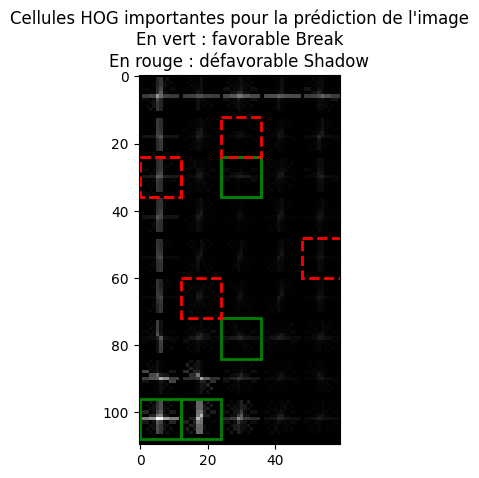

In [ ]:
# Affichage des features HOG favorables à la classe Break et défavorables à la classe Shadow
show_hog_cell(img,
              [217,1515,1522,1627,509],"Break",# pour les index : faire -1 par rapport au nom des features retournées par LIME
              [944,1299,57,487,49],"Shadow")

La zone en bas à gauche avec des gradients élevés contribue beaucoup pour la prédiction de la classe Break. En dehors de cette zone, des cellules HOG différentes ont permis de cibler la classe Break dans un cas, et d'éliminer la classe Shadow ailleurs.

Plusieurs **pixels bruts** figuraient parmi les features les plus importantes pour la classe Break. Localisons-les sur l'image.

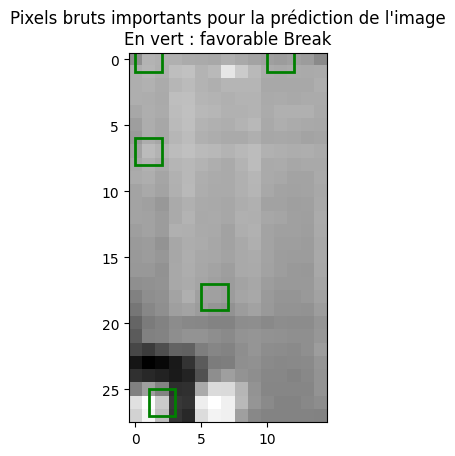

In [31]:
# Conversion de l'image en niveaux de gris et resizing conforme à l'extraction des pixels bruts de la pipeline
img_gray_resized = cv2.cvtColor(cv2.resize(img,(15,28)), cv2.COLOR_BGR2GRAY)

# Index des pixels les + importants (faire -1 par rapport au nom de la feature)
pixel_idxs_break = [392,1,276,106,11]

# Afficher l'image et entourer les pixels correspondants
fig, ax = plt.subplots()
ax.imshow(img_gray_resized, cmap='gray')

# Pour chaque n° de pixel identifié pour break
for pixel_idx in pixel_idxs_break:
    # Calculer sa position dans l'image
    pix_row = pixel_idx // img_gray_resized.shape[1]
    pix_col = pixel_idx % img_gray_resized.shape[1]

    # Dessiner un rectangle autour du pixel
    rect = plt.Rectangle(
        (pix_col -1, pix_row -1),
        2,
        2,
        edgecolor='green',
        facecolor='none',
        linewidth=2
    )
    ax.add_patch(rect)

plt.title(f"Pixels bruts importants pour la prédiction de l'image\nEn vert : favorable Break")
plt.show()

Visiblement, plusieurs pixels "clairs" répartis sur l'image ont contribué à prédire la classe Break.

On s'aperçoit, avec l'image-test prise en exemple, que l'interprétabilité agnostique d'un modèle avec autant de features est plutôt complexe.

### Explication d'une instance où le modèle a vu juste

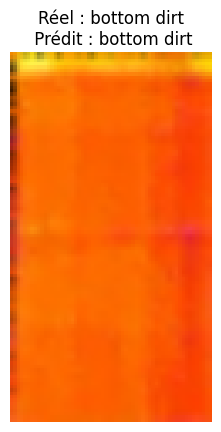

In [50]:
# On choisit une instance de test à expliquer
instance_idx = 56
img = cv2.imread(X_test.iloc[instance_idx]["Chemin"])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Réel : {y_test.iloc[instance_idx]}\n Prédit : {y_pred[instance_idx]}")
plt.show()

On va essayer d'expliquer pourquoi le modèle a prédit, à juste titre, la classe Bottom Dirt

In [53]:
predicted_class_idx = end_pipe.classes_.tolist().index("bottom dirt")
print (f"Probabilité prédiction classe bottom dirt : {y_pred_proba[instance_idx][predicted_class_idx]}")

Probabilité prédiction classe bottom dirt : 0.9719241365981244


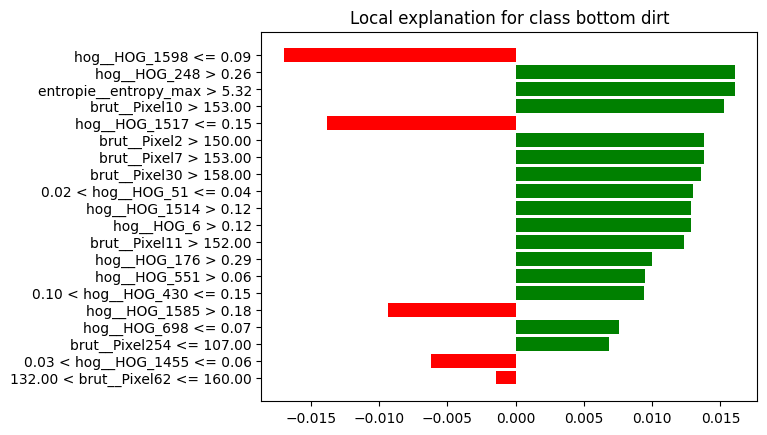

In [54]:
# Générer l'explication sur l'instance de test choisie (transformée)
explanation = explainer.explain_instance(
    data_row=X_test_transformed.iloc[instance_idx].to_numpy(),
    predict_fn= end_pipe.predict_proba,
    num_features=20,
    labels=np.arange(len(end_pipe.classes_))
)

# Afficher l'explication sous forme de graphique pour la classe prédite
fig = explanation.as_pyplot_figure(label=predicted_class_idx)
plt.show()

Parmi les features qui ont contribué à cette prédiction, on note :
- une entropie max élevée, indiquant une zone dans l'image où il y a une forte variation d'intensité
- des valeurs de gradients (HOG) et de pixels bruts relativement élevés. Nous allons vérifier l'emplacement de ces gradients et pixels dans l'image.

On remarque aussi que certaines features HOG ont eu un impact négatif assez fort quant à la prédiction de la classe Bottom Dirt. Nous allons aussi les étudier.

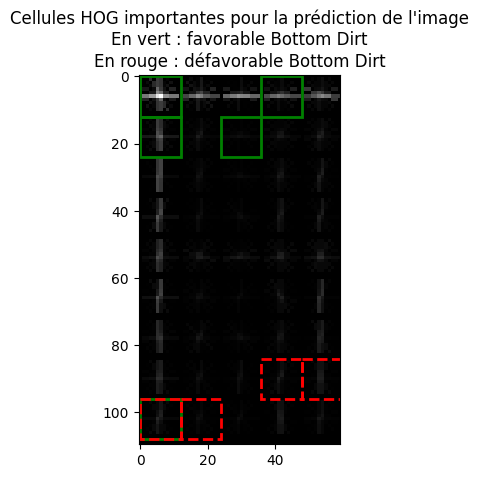

In [59]:
# Affichage des features HOG favorables et défavorables à la classe Bottom Dirt
show_hog_cell(img,
              [247,50,1513,5,175],"Bottom Dirt",
              [1597,1516,1584,1454],"Bottom Dirt"
              )# pour les index : faire -1 par rapport au nom des features retournées par LIME

On remarque que les gradients à valeur élevée en haut de l'image ont particulièrement contribué à la prédiction de la classe Bottom dirt : c'est effectivement dans cette zone que se trouve la bande de salissure qui a engendré une variation de température.

On voit aussi que les gradients en bas de l'image, plutôt faibles dans ce cas, ont eu tendance à discréditer cette même classe bottom dirt. Notre modèle a été effectivement entraîné sur des images où les bandes de salissure se trouvent soit en haut soit en bas de l'image. Le fait que'il ne se "passe rien" en bas de l'image n'est donc pas favorable à la classe Bottom Dirt. 

Plusieurs **pixels bruts** figuraient parmi les features les plus importantes de la classe Bottom Dirt. Localisons-les sur l'image.

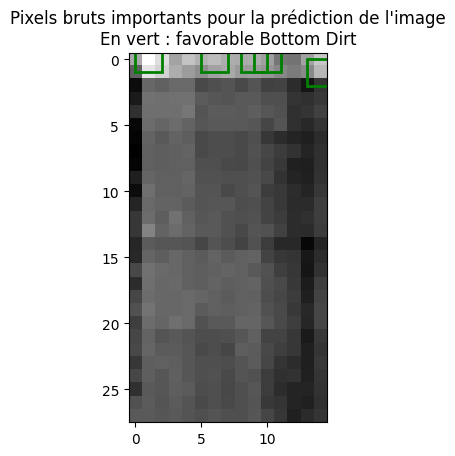

In [60]:
# Conversion de l'image en niveaux de gris et resizing conforme à l'extraction des pixels bruts de la pipeline
img_gray_resized = cv2.cvtColor(cv2.resize(img,(15,28)), cv2.COLOR_BGR2GRAY)

# Index des pixels les + importants (faire -1 par rapport au nom de la feature)
pixel_idxs_break = [9,1,6,29,10]

# Afficher l'image et entourer les pixels correspondants
fig, ax = plt.subplots()
ax.imshow(img_gray_resized, cmap='gray')

# Pour chaque n° de pixel identifié pour Bottom Dirt
for pixel_idx in pixel_idxs_break:
    # Calculer sa position dans l'image
    pix_row = pixel_idx // img_gray_resized.shape[1]
    pix_col = pixel_idx % img_gray_resized.shape[1]

    # Dessiner un rectangle autour du pixel
    rect = plt.Rectangle(
        (pix_col -1, pix_row -1),
        2,
        2,
        edgecolor='green',
        facecolor='none',
        linewidth=2
    )
    ax.add_patch(rect)

plt.title(f"Pixels bruts importants pour la prédiction de l'image\nEn vert : favorable Bottom Dirt")
plt.show()

Les pixels en haut de l'image avec une intensité élevée ont donc contribué à prédire la classe Bottom Dirt. Logique : c'est bien à cet endroit que la salissure accumulée au bord du panneau a entraîné une hausse de la température.

# 10. Généralisation hors dataset

Voyons sur quelques images de panneaux trouvées **hors dataset** si notre modèle arrive à détecter des défauts

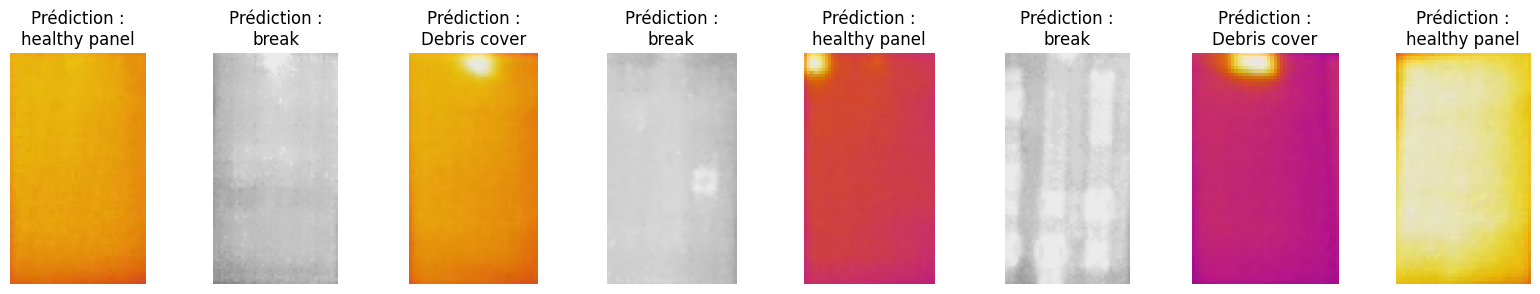

In [21]:
# On revient sur le découpage train / test de départ
X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="110x60")
my_pipeline.fit(X_train,y_train)

# Quelques images de test hors dataset pour la prédiction
plt.figure(figsize=(20, 3))
for i,unit_test_path in enumerate(["UT_images_ext/UT_healthy.png",
                                   "UT_images_ext/UT_junction_box.png",
                                   "UT_images_ext/UT_junction_box_2.png",
                                   "UT_images_ext/UT_one_cell.png",
                                   "UT_images_ext/UT_one_cell_2.png",
                                   "UT_images_ext/UT_multi_cell.png",
                                   "UT_images_ext/UT_multi_cell_2.png",
                                   "UT_images_ext/UT_module.png"]):
    unit_test = pd.DataFrame({"Chemin":[unit_test_path]})
    unit_pred = my_pipeline.predict(unit_test)
    plt.subplot(1, 8, i+1)
    img = cv2.imread(unit_test_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Prédiction :\n{unit_pred[0]}")
plt.show()

Le modèle arrive à détecter des défauts. Par contre, il classe 2 images healthy alors qu'elles ne le sont visiblement pas.


On touche là à la **limite identifiée au début du projet**. Le système d'acquisition, la construction d'images IR et l'environnement peuvent beaucoup varier d'une ferme photovoltaïque à l'autre. Même si notre dataset est issu de 8 fermes photovoltaïques différentes avec des conditions de prise d'images variées, il ne pourra être universellement efficace.